In [1]:
import numpy as np
import meshio
import torch
import tensorflow.compat.v1 as tf

from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import pandas as pd
import os
import time
from IPython.lib.display import isdir
import random
import matplotlib.pyplot as plt
import copy
from matplotlib import tri as mtri
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from circle_pooling import *
#from mgn import *
from tap_processing import *
#from global_tpok_mp import *

from circle_TAP_MP_Attention import *
from GTF import *

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


"""准备数据"""

In [2]:
number_trajectories=1
number_ts=200   #400
satart_number_ts=50
per_t=1     #在编码和解码的时候每五个用的点是一样的
dt=0.1
batch_size = 25
dataset_dir = '/root/data1/circle_fenjie_EMD'
path='/root/data1/yuan_'
#get_dataset(number_trajectories,satart_number_ts,number_ts,per_t,batch_size,dataset_dir,path)

In [3]:
get_dataset(number_trajectories,satart_number_ts,number_ts,1,1,dataset_dir,path)
data_list_ori=torch.load(dataset_dir+'/meshgraphnets_miniset'+str(1)+str(1)+
               str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
print(len(data_list_ori))
number=int(len(data_list_ori)/number_trajectories)

pool_num =[3300,2500,1500]#[3300,2900,2300]#3718

data_list_ori=data_list_ori[:100]

data_list_pick=copy.deepcopy(data_list_ori)

perms=[]
perm_list=[]
ratio_1_list=[800,600,400]#[1600,1425,1025]
ratio_2_list=[600,500,350]#[1600,1425,1025]
ratio_3_list=[600,500,350]#[1600,1425,1025]

ratio_4_list=[400,300,200]#[1600,1425,1025]
ratio_5_list=[400,300,200]
ratio_6_list=[1200,1000,900]#[1000,800,500]



x_min_1=0
x_max_1=0.2
y_min_1=0
y_max_1=0.41

x_min_2=0.2
x_max_2=0.6
y_min_2=0.2
y_max_2=0.41

x_min_3=0.2
x_max_3=0.6
y_min_3=0
y_max_3=0.2

x_min_4=0.6
x_max_4=2.2
y_min_4=0.2
y_max_4=0.41

x_min_5=0.6
x_max_5=2.2
y_min_5=0
y_max_5=0.2

x_min_6=0
x_max_6=2.2
y_min_6=0
y_max_6=0.41




for i in range(len(pool_num)):
      for j in range(len(data_list_ori)):
              if j==0:
                     sc=data_list_pick[j].x.new_zeros(data_list_pick[j].x.size(0))
              ratio_1=ratio_1_list[i]
              ratio_2=ratio_2_list[i]
              ratio_3=ratio_3_list[i]
              ratio_4=ratio_4_list[i]
              ratio_5=ratio_5_list[i]
              ratio_6=ratio_6_list[i]
              
              
              min_score= None
              x=data_list_pick[j].x
              edge_index=data_list_pick[j].edge_index
              pos=data_list_pick[j].mesh_pos
              #mask=x.new_zeros(x.size(0))
              mask=TAPooling_Mod(x, pos,ratio_1,ratio_2,ratio_3,ratio_4,ratio_5,ratio_6,
                                 x_min_1,x_max_1,y_min_1,y_max_1,
                   x_min_2,x_max_2,y_min_2,y_max_2,x_min_3,x_max_3,y_min_3,y_max_3,
                   x_min_4,x_max_4,y_min_4,y_max_4,
                   x_min_5,x_max_5,y_min_5,y_max_5,
                   
                   x_min_6,x_max_6,y_min_6,y_max_6,
                   
                   min_score,edge_index,
                                               edge_attr=None, batch=None, attn=None)
              #mask[perm]=1
              mask=mask.to('cpu')
              sc=sc+mask
              

      _, perm =sc.sort(dim=-1, descending=True)
      print(len(perm))
      mask = [torch.arange(pool_num[i], dtype=torch.long) ]
      perm = perm[mask]
      print(len(perm))
      perms += [perm]
      for k in range(len(data_list_ori)):
            edge_index=data_list_pick[k].edge_index
            edge_attr=data_list_pick[k].edge_attr
            edge_index, edge_attr, edge_mask = filter_adj(edge_index, edge_attr, perm,
                                           num_nodes=data_list_pick[k].x.size(0))
            data_list_pick[k]. x = data_list_pick[k]. x[perm]
            data_list_pick[k].mesh_pos  = data_list_pick[k].mesh_pos[perm]
            data_list_pick[k].edge_index= edge_index
            data_list_pick[k]. edge_attr =  edge_attr
            #print(data_list_pick[k]. x .shape,data_list_pick[k].edge_index.shape,data_list_pick[k]. edge_attr.shape)        
             
             
      

perm_list.append(perms)

torch.save(perm_list,dataset_dir+'/perm_list_150.pt')

/root/data1/yuan_0
402
Done collecting data!
Done saving data!
Output Location:  /root/data1/circle_fenjie_EMD/meshgraphnets_miniset111traj50200ts_vis.pt
200
3718
3300
3300
2500
2500
1500


optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #weight_decay=1e-4
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                patience=10, threshold=0.0000001, threshold_mode='rel',
                                cooldown=0, min_lr=0.000001, eps=1e-08, verbose=True)
if epoch%50==0 and epoch>=250:
            optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #weight_decay=1e-4
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                patience=5, threshold=0.0000001, threshold_mode='rel',
                                cooldown=0, min_lr=0.000001, eps=1e-08, verbose=True)

cuda
cuda:0
8
Data(x=[92950, 2], edge_index=[2, 21714], edge_attr=[21714, 3], cells=[7139, 3], mesh_pos=[3718, 2])


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training:   0%|          | 1/400 [00:31<3:27:27, 31.20s/Epochs]

Epoch: 0000,	Train mse: 0.83635272,	Train_RMSE: 0.91262545,	Train_acc: 0.91267312,	Test mse: 0.63140178,	Time: 31.19747281s


Training:   1%|          | 3/400 [01:30<3:17:56, 29.91s/Epochs]

Epoch: 0002,	Train mse: 0.50617868,	Train_RMSE: 0.70989949,	Train_acc: 0.70993114,	Test mse: 0.45142356,	Time: 29.50487542s


Training:   1%|▏         | 5/400 [02:30<3:17:40, 30.03s/Epochs]

Epoch: 0004,	Train mse: 0.34122840,	Train_RMSE: 0.58361348,	Train_acc: 0.58363688,	Test mse: 0.33815467,	Time: 30.10000348s


Training:   2%|▏         | 7/400 [03:29<3:14:52, 29.75s/Epochs]

Epoch: 0006,	Train mse: 0.19249978,	Train_RMSE: 0.43813404,	Train_acc: 0.43815589,	Test mse: 0.17466006,	Time: 29.20704699s


Training:   2%|▏         | 9/400 [04:29<3:14:41, 29.88s/Epochs]

Epoch: 0008,	Train mse: 0.15668019,	Train_RMSE: 0.39542219,	Train_acc: 0.39544141,	Test mse: 0.13059616,	Time: 29.68659735s


Training:   3%|▎         | 11/400 [05:28<3:11:07, 29.48s/Epochs]

Epoch: 0010,	Train mse: 0.09465801,	Train_RMSE: 0.30749854,	Train_acc: 0.30751118,	Test mse: 0.08311265,	Time: 28.90620947s


Training:   3%|▎         | 13/400 [06:24<3:06:20, 28.89s/Epochs]

Epoch: 0012,	Train mse: 0.20812714,	Train_RMSE: 0.45289427,	Train_acc: 0.45290488,	Test mse: 0.21641496,	Time: 28.08373070s


Training:   4%|▍         | 15/400 [07:20<3:02:34, 28.45s/Epochs]

Epoch: 0014,	Train mse: 0.13649493,	Train_RMSE: 0.36878933,	Train_acc: 0.36880228,	Test mse: 0.14799491,	Time: 28.20075274s


Training:   4%|▍         | 17/400 [08:16<2:59:41, 28.15s/Epochs]

Epoch: 0016,	Train mse: 0.08711712,	Train_RMSE: 0.29474636,	Train_acc: 0.29476413,	Test mse: 0.07686910,	Time: 27.68496609s


Training:   5%|▍         | 19/400 [09:12<2:57:48, 28.00s/Epochs]

Epoch: 0018,	Train mse: 0.05950313,	Train_RMSE: 0.24389024,	Train_acc: 0.24389912,	Test mse: 0.05540180,	Time: 27.89305806s


Training:   5%|▌         | 21/400 [10:07<2:55:15, 27.75s/Epochs]

Epoch: 0020,	Train mse: 0.04880398,	Train_RMSE: 0.22090317,	Train_acc: 0.22091107,	Test mse: 0.06191252,	Time: 27.49890947s


Training:   6%|▌         | 23/400 [11:02<2:53:28, 27.61s/Epochs]

Epoch: 0022,	Train mse: 0.06270235,	Train_RMSE: 0.25025960,	Train_acc: 0.25027022,	Test mse: 0.05697712,	Time: 27.59872866s


Training:   6%|▋         | 25/400 [11:58<2:54:46, 27.96s/Epochs]

Epoch: 0024,	Train mse: 0.04657359,	Train_RMSE: 0.21576325,	Train_acc: 0.21577112,	Test mse: 0.04306591,	Time: 29.00795603s


Training:   7%|▋         | 27/400 [12:57<2:58:51, 28.77s/Epochs]

Epoch: 0026,	Train mse: 0.08751757,	Train_RMSE: 0.29546051,	Train_acc: 0.29547068,	Test mse: 0.07725524,	Time: 29.30027723s


Training:   7%|▋         | 29/400 [13:56<2:59:34, 29.04s/Epochs]

Epoch: 0028,	Train mse: 0.05218868,	Train_RMSE: 0.22830721,	Train_acc: 0.22831687,	Test mse: 0.04837048,	Time: 29.09347010s


Training:   8%|▊         | 31/400 [14:55<2:59:12, 29.14s/Epochs]

Epoch: 0030,	Train mse: 0.03998832,	Train_RMSE: 0.19994193,	Train_acc: 0.19994906,	Test mse: 0.03811992,	Time: 29.11020160s


Training:   8%|▊         | 33/400 [15:51<2:55:36, 28.71s/Epochs]

Epoch: 0032,	Train mse: 0.05066598,	Train_RMSE: 0.22450887,	Train_acc: 0.22451457,	Test mse: 0.03845171,	Time: 27.59444380s


Training:   9%|▉         | 35/400 [16:47<2:51:28, 28.19s/Epochs]

Epoch: 0034,	Train mse: 0.03836527,	Train_RMSE: 0.19583083,	Train_acc: 0.19583564,	Test mse: 0.03553689,	Time: 27.60573363s


Training:   9%|▉         | 37/400 [17:43<2:49:52, 28.08s/Epochs]

Epoch: 0036,	Train mse: 0.03474588,	Train_RMSE: 0.18638919,	Train_acc: 0.18639579,	Test mse: 0.03584480,	Time: 27.59448075s


Training:  10%|▉         | 39/400 [18:39<2:48:38, 28.03s/Epochs]

Epoch: 0038,	Train mse: 0.03694891,	Train_RMSE: 0.19204021,	Train_acc: 0.19205041,	Test mse: 0.03656191,	Time: 28.18663812s


Training:  10%|█         | 41/400 [19:34<2:46:01, 27.75s/Epochs]

Epoch: 0040,	Train mse: 0.03335562,	Train_RMSE: 0.18262296,	Train_acc: 0.18262954,	Test mse: 0.03315282,	Time: 27.58402562s


Training:  11%|█         | 43/400 [20:29<2:44:36, 27.67s/Epochs]

Epoch: 0042,	Train mse: 0.03194473,	Train_RMSE: 0.17869868,	Train_acc: 0.17870502,	Test mse: 0.03249930,	Time: 27.49827814s


Training:  11%|█▏        | 45/400 [21:27<2:48:13, 28.43s/Epochs]

Epoch: 0044,	Train mse: 0.03371740,	Train_RMSE: 0.18349109,	Train_acc: 0.18349594,	Test mse: 0.03306916,	Time: 29.29256630s


Training:  12%|█▏        | 47/400 [22:25<2:48:46, 28.69s/Epochs]

Epoch: 0046,	Train mse: 0.04086082,	Train_RMSE: 0.20088759,	Train_acc: 0.20088784,	Test mse: 0.04416508,	Time: 28.80591488s


Training:  12%|█▏        | 48/400 [22:54<2:49:01, 28.81s/Epochs]

Epoch    48: reducing learning rate of group 0 to 5.0000e-03.


Training:  12%|█▏        | 49/400 [23:24<2:49:33, 28.98s/Epochs]

Epoch: 0048,	Train mse: 0.03501662,	Train_RMSE: 0.18695249,	Train_acc: 0.18696181,	Test mse: 0.03108037,	Time: 29.39046335s


Training:  13%|█▎        | 51/400 [24:22<2:49:43, 29.18s/Epochs]

Epoch: 0050,	Train mse: 0.02954922,	Train_RMSE: 0.17187449,	Train_acc: 0.17187995,	Test mse: 0.02811431,	Time: 29.19423890s


Training:  13%|█▎        | 53/400 [25:20<2:48:19, 29.10s/Epochs]

Epoch: 0052,	Train mse: 0.02776847,	Train_RMSE: 0.16662458,	Train_acc: 0.16663048,	Test mse: 0.02697926,	Time: 29.19914627s


Training:  14%|█▍        | 55/400 [26:19<2:47:43, 29.17s/Epochs]

Epoch: 0054,	Train mse: 0.02678543,	Train_RMSE: 0.16364914,	Train_acc: 0.16365474,	Test mse: 0.02619984,	Time: 28.90852094s


Training:  14%|█▍        | 57/400 [27:16<2:45:15, 28.91s/Epochs]

Epoch: 0056,	Train mse: 0.02619773,	Train_RMSE: 0.16184367,	Train_acc: 0.16184935,	Test mse: 0.02576619,	Time: 28.70295429s


Training:  15%|█▍        | 59/400 [28:13<2:42:13, 28.54s/Epochs]

Epoch: 0058,	Train mse: 0.02559393,	Train_RMSE: 0.15996563,	Train_acc: 0.15997115,	Test mse: 0.02506005,	Time: 27.68938780s


Training:  15%|█▌        | 61/400 [29:08<2:38:44, 28.10s/Epochs]

Epoch: 0060,	Train mse: 0.02491347,	Train_RMSE: 0.15782409,	Train_acc: 0.15782955,	Test mse: 0.02448791,	Time: 27.98437452s


Training:  16%|█▌        | 63/400 [30:03<2:35:10, 27.63s/Epochs]

Epoch: 0062,	Train mse: 0.02442089,	Train_RMSE: 0.15625450,	Train_acc: 0.15626001,	Test mse: 0.02395447,	Time: 26.79486036s


Training:  16%|█▋        | 65/400 [30:57<2:33:21, 27.47s/Epochs]

Epoch: 0064,	Train mse: 0.02600195,	Train_RMSE: 0.16121842,	Train_acc: 0.16122381,	Test mse: 0.02546033,	Time: 27.39972138s


Training:  17%|█▋        | 67/400 [31:52<2:32:17, 27.44s/Epochs]

Epoch: 0066,	Train mse: 0.02438033,	Train_RMSE: 0.15611131,	Train_acc: 0.15611669,	Test mse: 0.02321211,	Time: 27.49811292s


Training:  17%|█▋        | 69/400 [32:48<2:32:46, 27.69s/Epochs]

Epoch: 0068,	Train mse: 0.02362932,	Train_RMSE: 0.15370026,	Train_acc: 0.15370546,	Test mse: 0.02285514,	Time: 27.81038094s


Training:  18%|█▊        | 71/400 [33:48<2:38:24, 28.89s/Epochs]

Epoch: 0070,	Train mse: 0.02480956,	Train_RMSE: 0.15746286,	Train_acc: 0.15746790,	Test mse: 0.02312712,	Time: 30.00534058s


Training:  18%|█▊        | 73/400 [34:46<2:38:16, 29.04s/Epochs]

Epoch: 0072,	Train mse: 0.02284004,	Train_RMSE: 0.15109472,	Train_acc: 0.15110026,	Test mse: 0.02234250,	Time: 28.89789796s


Training:  19%|█▉        | 75/400 [35:45<2:37:32, 29.09s/Epochs]

Epoch: 0074,	Train mse: 0.02733700,	Train_RMSE: 0.16496544,	Train_acc: 0.16497169,	Test mse: 0.02500502,	Time: 29.00513268s


Training:  19%|█▉        | 77/400 [36:44<2:37:58, 29.34s/Epochs]

Epoch: 0076,	Train mse: 0.02295141,	Train_RMSE: 0.15146625,	Train_acc: 0.15147145,	Test mse: 0.02188551,	Time: 29.79892945s


Training:  20%|█▉        | 79/400 [37:43<2:38:16, 29.58s/Epochs]

Epoch: 0078,	Train mse: 0.02282254,	Train_RMSE: 0.15101385,	Train_acc: 0.15101872,	Test mse: 0.02951591,	Time: 29.89868379s


Training:  20%|██        | 81/400 [38:42<2:36:44, 29.48s/Epochs]

Epoch: 0080,	Train mse: 0.02336630,	Train_RMSE: 0.15279043,	Train_acc: 0.15279530,	Test mse: 0.02322869,	Time: 29.50061512s


Training:  21%|██        | 83/400 [39:43<2:37:58, 29.90s/Epochs]

Epoch: 0082,	Train mse: 0.02188572,	Train_RMSE: 0.14790622,	Train_acc: 0.14791176,	Test mse: 0.02122311,	Time: 29.88123965s


Training:  21%|██▏       | 85/400 [40:42<2:35:57, 29.71s/Epochs]

Epoch: 0084,	Train mse: 0.02913570,	Train_RMSE: 0.16999578,	Train_acc: 0.16999923,	Test mse: 0.02669597,	Time: 29.60557556s


Training:  22%|██▏       | 87/400 [41:40<2:32:40, 29.27s/Epochs]

Epoch: 0086,	Train mse: 0.02243424,	Train_RMSE: 0.14970820,	Train_acc: 0.14971307,	Test mse: 0.02174812,	Time: 28.30331373s


Training:  22%|██▏       | 88/400 [42:09<2:31:57, 29.22s/Epochs]

Epoch    88: reducing learning rate of group 0 to 2.5000e-03.


Training:  22%|██▏       | 89/400 [42:38<2:31:34, 29.24s/Epochs]

Epoch: 0088,	Train mse: 0.02069303,	Train_RMSE: 0.14380302,	Train_acc: 0.14380881,	Test mse: 0.02007949,	Time: 29.28308296s


Training:  23%|██▎       | 91/400 [43:37<2:30:07, 29.15s/Epochs]

Epoch: 0090,	Train mse: 0.01990332,	Train_RMSE: 0.14104590,	Train_acc: 0.14105101,	Test mse: 0.01931678,	Time: 28.39083791s


Training:  23%|██▎       | 93/400 [44:36<2:29:51, 29.29s/Epochs]

Epoch: 0092,	Train mse: 0.01950736,	Train_RMSE: 0.13963411,	Train_acc: 0.13963923,	Test mse: 0.01899138,	Time: 29.50645661s


Training:  24%|██▍       | 95/400 [45:34<2:28:11, 29.15s/Epochs]

Epoch: 0094,	Train mse: 0.01921310,	Train_RMSE: 0.13857629,	Train_acc: 0.13858140,	Test mse: 0.01872187,	Time: 28.90227461s


Training:  24%|██▍       | 97/400 [46:31<2:26:26, 29.00s/Epochs]

Epoch: 0096,	Train mse: 0.01902128,	Train_RMSE: 0.13788218,	Train_acc: 0.13788730,	Test mse: 0.01848370,	Time: 28.39115715s


Training:  25%|██▍       | 99/400 [47:29<2:24:47, 28.86s/Epochs]

Epoch: 0098,	Train mse: 0.01877267,	Train_RMSE: 0.13697688,	Train_acc: 0.13698202,	Test mse: 0.01822766,	Time: 28.18592644s


Training:  25%|██▌       | 101/400 [48:25<2:20:59, 28.29s/Epochs]

Epoch: 0100,	Train mse: 0.01858245,	Train_RMSE: 0.13628189,	Train_acc: 0.13628700,	Test mse: 0.01804136,	Time: 27.70295358s


Training:  26%|██▌       | 103/400 [49:20<2:17:51, 27.85s/Epochs]

Epoch: 0102,	Train mse: 0.01838511,	Train_RMSE: 0.13555749,	Train_acc: 0.13556246,	Test mse: 0.01793899,	Time: 27.29845548s


Training:  26%|██▋       | 105/400 [50:15<2:16:22, 27.74s/Epochs]

Epoch: 0104,	Train mse: 0.01816821,	Train_RMSE: 0.13475554,	Train_acc: 0.13476047,	Test mse: 0.01758364,	Time: 27.30909300s


Training:  27%|██▋       | 107/400 [51:09<2:14:20, 27.51s/Epochs]

Epoch: 0106,	Train mse: 0.01784618,	Train_RMSE: 0.13355165,	Train_acc: 0.13355665,	Test mse: 0.01729956,	Time: 27.48508072s


Training:  27%|██▋       | 109/400 [52:06<2:15:05, 27.85s/Epochs]

Epoch: 0108,	Train mse: 0.01771303,	Train_RMSE: 0.13304773,	Train_acc: 0.13305274,	Test mse: 0.01771970,	Time: 28.30681682s


Training:  28%|██▊       | 111/400 [53:02<2:14:50, 27.99s/Epochs]

Epoch: 0110,	Train mse: 0.01791221,	Train_RMSE: 0.13379387,	Train_acc: 0.13379882,	Test mse: 0.01706808,	Time: 27.80441260s


Training:  28%|██▊       | 113/400 [53:58<2:13:58, 28.01s/Epochs]

Epoch: 0112,	Train mse: 0.01739473,	Train_RMSE: 0.13184474,	Train_acc: 0.13184981,	Test mse: 0.01702512,	Time: 27.81705999s


Training:  29%|██▉       | 115/400 [54:57<2:16:12, 28.67s/Epochs]

Epoch: 0114,	Train mse: 0.01717840,	Train_RMSE: 0.13102333,	Train_acc: 0.13102826,	Test mse: 0.01674820,	Time: 28.90744710s


Training:  29%|██▉       | 117/400 [55:56<2:17:47, 29.21s/Epochs]

Epoch: 0116,	Train mse: 0.01700160,	Train_RMSE: 0.13033281,	Train_acc: 0.13033788,	Test mse: 0.01647805,	Time: 29.89230609s


Training:  30%|██▉       | 119/400 [56:55<2:17:18, 29.32s/Epochs]

Epoch: 0118,	Train mse: 0.01830420,	Train_RMSE: 0.13518229,	Train_acc: 0.13518816,	Test mse: 0.01751161,	Time: 29.27824402s


Training:  30%|███       | 121/400 [57:54<2:16:24, 29.33s/Epochs]

Epoch: 0120,	Train mse: 0.01707386,	Train_RMSE: 0.13060639,	Train_acc: 0.13061136,	Test mse: 0.01616981,	Time: 29.09319663s


Training:  31%|███       | 123/400 [58:52<2:14:54, 29.22s/Epochs]

Epoch: 0122,	Train mse: 0.01653619,	Train_RMSE: 0.12854677,	Train_acc: 0.12855172,	Test mse: 0.01602448,	Time: 29.18798494s


Training:  31%|███▏      | 125/400 [59:51<2:13:57, 29.23s/Epochs]

Epoch: 0124,	Train mse: 0.01654651,	Train_RMSE: 0.12859533,	Train_acc: 0.12860022,	Test mse: 0.01583484,	Time: 29.11698008s


Training:  32%|███▏      | 127/400 [1:00:49<2:12:55, 29.22s/Epochs]

Epoch: 0126,	Train mse: 0.01642282,	Train_RMSE: 0.12808730,	Train_acc: 0.12809221,	Test mse: 0.01617872,	Time: 28.99499726s


Training:  32%|███▏      | 129/400 [1:01:46<2:09:36, 28.70s/Epochs]

Epoch: 0128,	Train mse: 0.01640727,	Train_RMSE: 0.12801799,	Train_acc: 0.12802324,	Test mse: 0.01561923,	Time: 28.40445828s


Training:  33%|███▎      | 131/400 [1:02:40<2:05:20, 27.96s/Epochs]

Epoch: 0130,	Train mse: 0.01609764,	Train_RMSE: 0.12680313,	Train_acc: 0.12680814,	Test mse: 0.01563925,	Time: 27.00546622s


Training:  33%|███▎      | 133/400 [1:03:36<2:04:21, 27.95s/Epochs]

Epoch: 0132,	Train mse: 0.01672293,	Train_RMSE: 0.12923411,	Train_acc: 0.12923859,	Test mse: 0.02086190,	Time: 27.89229107s


Training:  34%|███▍      | 135/400 [1:04:34<2:05:00, 28.31s/Epochs]

Epoch: 0134,	Train mse: 0.01783094,	Train_RMSE: 0.13341947,	Train_acc: 0.13342611,	Test mse: 0.01694566,	Time: 28.19247580s
Epoch   135: reducing learning rate of group 0 to 1.2500e-03.


Training:  34%|███▍      | 137/400 [1:05:28<2:01:31, 27.72s/Epochs]

Epoch: 0136,	Train mse: 0.01592505,	Train_RMSE: 0.12613010,	Train_acc: 0.12613504,	Test mse: 0.01518635,	Time: 26.99470925s


Training:  35%|███▍      | 139/400 [1:06:26<2:03:16, 28.34s/Epochs]

Epoch: 0138,	Train mse: 0.01539216,	Train_RMSE: 0.12400579,	Train_acc: 0.12401080,	Test mse: 0.01486895,	Time: 29.28508425s


Training:  35%|███▌      | 141/400 [1:07:25<2:04:51, 28.92s/Epochs]

Epoch: 0140,	Train mse: 0.01516154,	Train_RMSE: 0.12307343,	Train_acc: 0.12307832,	Test mse: 0.01466595,	Time: 29.89292431s


Training:  36%|███▌      | 143/400 [1:08:24<2:05:24, 29.28s/Epochs]

Epoch: 0142,	Train mse: 0.01503606,	Train_RMSE: 0.12256030,	Train_acc: 0.12256522,	Test mse: 0.01454515,	Time: 29.70524335s


Training:  36%|███▋      | 145/400 [1:09:23<2:05:06, 29.44s/Epochs]

Epoch: 0144,	Train mse: 0.01493397,	Train_RMSE: 0.12214188,	Train_acc: 0.12214677,	Test mse: 0.01444461,	Time: 29.99947214s


Training:  37%|███▋      | 147/400 [1:10:23<2:05:16, 29.71s/Epochs]

Epoch: 0146,	Train mse: 0.01484902,	Train_RMSE: 0.12179459,	Train_acc: 0.12179948,	Test mse: 0.01437064,	Time: 29.59378338s


Training:  37%|███▋      | 149/400 [1:11:20<2:02:09, 29.20s/Epochs]

Epoch: 0148,	Train mse: 0.01475960,	Train_RMSE: 0.12142504,	Train_acc: 0.12142994,	Test mse: 0.01427357,	Time: 28.98838043s


Training:  38%|███▊      | 151/400 [1:12:19<2:01:44, 29.34s/Epochs]

Epoch: 0150,	Train mse: 0.01467031,	Train_RMSE: 0.12105626,	Train_acc: 0.12106115,	Test mse: 0.01417876,	Time: 29.79994154s


Training:  38%|███▊      | 153/400 [1:13:17<2:00:29, 29.27s/Epochs]

Epoch: 0152,	Train mse: 0.01459049,	Train_RMSE: 0.12072550,	Train_acc: 0.12073037,	Test mse: 0.01409310,	Time: 29.19529653s


Training:  39%|███▉      | 155/400 [1:14:14<1:57:44, 28.83s/Epochs]

Epoch: 0154,	Train mse: 0.01450352,	Train_RMSE: 0.12036610,	Train_acc: 0.12037095,	Test mse: 0.01402398,	Time: 28.28402710s


Training:  39%|███▉      | 157/400 [1:15:09<1:54:08, 28.18s/Epochs]

Epoch: 0156,	Train mse: 0.01443506,	Train_RMSE: 0.12007821,	Train_acc: 0.12008308,	Test mse: 0.01394756,	Time: 27.80327368s


Training:  40%|███▉      | 159/400 [1:16:05<1:52:08, 27.92s/Epochs]

Epoch: 0158,	Train mse: 0.01435146,	Train_RMSE: 0.11973064,	Train_acc: 0.11973548,	Test mse: 0.01383449,	Time: 27.50755286s


Training:  40%|████      | 161/400 [1:17:00<1:50:53, 27.84s/Epochs]

Epoch: 0160,	Train mse: 0.01429105,	Train_RMSE: 0.11947643,	Train_acc: 0.11948123,	Test mse: 0.01374988,	Time: 27.59317327s


Training:  41%|████      | 163/400 [1:17:56<1:49:33, 27.74s/Epochs]

Epoch: 0162,	Train mse: 0.01420938,	Train_RMSE: 0.11913681,	Train_acc: 0.11914156,	Test mse: 0.01366148,	Time: 27.60014534s


Training:  41%|████▏     | 165/400 [1:18:51<1:48:45, 27.77s/Epochs]

Epoch: 0164,	Train mse: 0.01414843,	Train_RMSE: 0.11888082,	Train_acc: 0.11888561,	Test mse: 0.01361940,	Time: 27.78496623s


Training:  42%|████▏     | 167/400 [1:19:46<1:47:10, 27.60s/Epochs]

Epoch: 0166,	Train mse: 0.01410397,	Train_RMSE: 0.11869428,	Train_acc: 0.11869912,	Test mse: 0.01357331,	Time: 27.52200365s


Training:  42%|████▏     | 169/400 [1:20:41<1:45:59, 27.53s/Epochs]

Epoch: 0168,	Train mse: 0.01398287,	Train_RMSE: 0.11818315,	Train_acc: 0.11818809,	Test mse: 0.01349092,	Time: 27.60181046s


Training:  43%|████▎     | 171/400 [1:21:36<1:45:05, 27.53s/Epochs]

Epoch: 0170,	Train mse: 0.01390508,	Train_RMSE: 0.11785132,	Train_acc: 0.11785623,	Test mse: 0.01340345,	Time: 27.70493603s


Training:  43%|████▎     | 173/400 [1:22:31<1:44:29, 27.62s/Epochs]

Epoch: 0172,	Train mse: 0.01385494,	Train_RMSE: 0.11763525,	Train_acc: 0.11764008,	Test mse: 0.01333035,	Time: 28.10828447s


Training:  44%|████▍     | 175/400 [1:23:26<1:43:03, 27.48s/Epochs]

Epoch: 0174,	Train mse: 0.01374773,	Train_RMSE: 0.11718281,	Train_acc: 0.11718768,	Test mse: 0.01325452,	Time: 27.59116912s


Training:  44%|████▍     | 177/400 [1:24:22<1:43:13, 27.77s/Epochs]

Epoch: 0176,	Train mse: 0.01374293,	Train_RMSE: 0.11715764,	Train_acc: 0.11716249,	Test mse: 0.01312582,	Time: 28.07794309s


Training:  45%|████▍     | 179/400 [1:25:21<1:45:54, 28.76s/Epochs]

Epoch: 0178,	Train mse: 0.01357614,	Train_RMSE: 0.11644621,	Train_acc: 0.11645103,	Test mse: 0.01306802,	Time: 29.90056634s


Training:  45%|████▌     | 181/400 [1:26:22<1:48:18, 29.67s/Epochs]

Epoch: 0180,	Train mse: 0.01356876,	Train_RMSE: 0.11641140,	Train_acc: 0.11641631,	Test mse: 0.01308535,	Time: 30.59792161s


Training:  46%|████▌     | 183/400 [1:27:22<1:47:32, 29.74s/Epochs]

Epoch: 0182,	Train mse: 0.01345454,	Train_RMSE: 0.11591682,	Train_acc: 0.11592166,	Test mse: 0.01289200,	Time: 29.79526949s


Training:  46%|████▋     | 185/400 [1:28:20<1:45:51, 29.54s/Epochs]

Epoch: 0184,	Train mse: 0.01333284,	Train_RMSE: 0.11539328,	Train_acc: 0.11539818,	Test mse: 0.01283304,	Time: 29.59241438s


Training:  47%|████▋     | 187/400 [1:29:20<1:45:08, 29.62s/Epochs]

Epoch: 0186,	Train mse: 0.01327537,	Train_RMSE: 0.11514066,	Train_acc: 0.11514553,	Test mse: 0.01272918,	Time: 29.39547014s


Training:  47%|████▋     | 189/400 [1:30:19<1:43:54, 29.55s/Epochs]

Epoch: 0188,	Train mse: 0.01316940,	Train_RMSE: 0.11467993,	Train_acc: 0.11468478,	Test mse: 0.01260896,	Time: 29.39535904s


Training:  48%|████▊     | 191/400 [1:31:18<1:43:10, 29.62s/Epochs]

Epoch: 0190,	Train mse: 0.01319670,	Train_RMSE: 0.11480580,	Train_acc: 0.11481060,	Test mse: 0.01277913,	Time: 29.60544348s


Training:  48%|████▊     | 193/400 [1:32:17<1:41:53, 29.53s/Epochs]

Epoch: 0192,	Train mse: 0.01306777,	Train_RMSE: 0.11423717,	Train_acc: 0.11424202,	Test mse: 0.01251502,	Time: 29.70286942s


Training:  49%|████▉     | 195/400 [1:33:16<1:40:29, 29.41s/Epochs]

Epoch: 0194,	Train mse: 0.01317601,	Train_RMSE: 0.11472109,	Train_acc: 0.11472578,	Test mse: 0.01262656,	Time: 29.50379109s


Training:  49%|████▉     | 197/400 [1:34:15<1:39:38, 29.45s/Epochs]

Epoch: 0196,	Train mse: 0.01293444,	Train_RMSE: 0.11364758,	Train_acc: 0.11365250,	Test mse: 0.01235048,	Time: 29.40717220s


Training:  50%|████▉     | 199/400 [1:35:13<1:38:13, 29.32s/Epochs]

Epoch: 0198,	Train mse: 0.01279302,	Train_RMSE: 0.11302133,	Train_acc: 0.11302616,	Test mse: 0.01226176,	Time: 29.40621257s


Training:  50%|█████     | 201/400 [1:36:09<1:35:28, 28.79s/Epochs]

Epoch: 0200,	Train mse: 0.01301079,	Train_RMSE: 0.11394980,	Train_acc: 0.11395484,	Test mse: 0.01227222,	Time: 28.40701032s


Training:  51%|█████     | 203/400 [1:37:07<1:34:19, 28.73s/Epochs]

Epoch: 0202,	Train mse: 0.01306834,	Train_RMSE: 0.11423506,	Train_acc: 0.11424021,	Test mse: 0.01288357,	Time: 28.49725056s


Training:  51%|█████▏    | 205/400 [1:38:04<1:32:50, 28.56s/Epochs]

Epoch: 0204,	Train mse: 0.01281177,	Train_RMSE: 0.11311907,	Train_acc: 0.11312398,	Test mse: 0.01225282,	Time: 28.00217295s


Training:  52%|█████▏    | 207/400 [1:38:58<1:29:47, 27.92s/Epochs]

Epoch: 0206,	Train mse: 0.01257256,	Train_RMSE: 0.11204920,	Train_acc: 0.11205407,	Test mse: 0.01210408,	Time: 27.69813371s


Training:  52%|█████▏    | 209/400 [1:39:52<1:26:47, 27.26s/Epochs]

Epoch: 0208,	Train mse: 0.01278820,	Train_RMSE: 0.11299613,	Train_acc: 0.11300117,	Test mse: 0.01247916,	Time: 26.10371065s


Training:  53%|█████▎    | 211/400 [1:40:47<1:26:25, 27.44s/Epochs]

Epoch: 0210,	Train mse: 0.01273319,	Train_RMSE: 0.11275266,	Train_acc: 0.11275733,	Test mse: 0.01201332,	Time: 27.40125990s


Training:  53%|█████▎    | 213/400 [1:41:42<1:25:09, 27.32s/Epochs]

Epoch: 0212,	Train mse: 0.01251486,	Train_RMSE: 0.11178380,	Train_acc: 0.11178859,	Test mse: 0.01194812,	Time: 27.01072145s


Training:  54%|█████▍    | 215/400 [1:42:36<1:24:37, 27.44s/Epochs]

Epoch: 0214,	Train mse: 0.01233565,	Train_RMSE: 0.11097713,	Train_acc: 0.11098194,	Test mse: 0.01177598,	Time: 27.88780189s


Training:  54%|█████▍    | 217/400 [1:43:31<1:23:28, 27.37s/Epochs]

Epoch: 0216,	Train mse: 0.01229274,	Train_RMSE: 0.11078649,	Train_acc: 0.11079128,	Test mse: 0.01174949,	Time: 27.29695153s


Training:  55%|█████▍    | 219/400 [1:44:29<1:25:21, 28.29s/Epochs]

Epoch: 0218,	Train mse: 0.01265811,	Train_RMSE: 0.11245628,	Train_acc: 0.11246091,	Test mse: 0.01206505,	Time: 29.30233884s


Training:  55%|█████▌    | 221/400 [1:45:27<1:25:22, 28.62s/Epochs]

Epoch: 0220,	Train mse: 0.01231135,	Train_RMSE: 0.11086842,	Train_acc: 0.11087330,	Test mse: 0.01185561,	Time: 29.29894447s


Training:  56%|█████▌    | 223/400 [1:46:28<1:26:59, 29.49s/Epochs]

Epoch: 0222,	Train mse: 0.01232827,	Train_RMSE: 0.11095819,	Train_acc: 0.11096293,	Test mse: 0.01162222,	Time: 30.40010214s


Training:  56%|█████▋    | 225/400 [1:47:27<1:26:25, 29.63s/Epochs]

Epoch: 0224,	Train mse: 0.01221843,	Train_RMSE: 0.11046012,	Train_acc: 0.11046489,	Test mse: 0.01157177,	Time: 29.19162560s


Training:  57%|█████▋    | 227/400 [1:48:27<1:25:41, 29.72s/Epochs]

Epoch: 0226,	Train mse: 0.01211212,	Train_RMSE: 0.10997987,	Train_acc: 0.10998454,	Test mse: 0.01142715,	Time: 29.80828381s


Training:  57%|█████▋    | 229/400 [1:49:26<1:23:55, 29.45s/Epochs]

Epoch: 0228,	Train mse: 0.01226731,	Train_RMSE: 0.11066916,	Train_acc: 0.11067405,	Test mse: 0.01186175,	Time: 29.09611630s


Training:  58%|█████▊    | 231/400 [1:50:24<1:22:16, 29.21s/Epochs]

Epoch: 0230,	Train mse: 0.01215932,	Train_RMSE: 0.11018613,	Train_acc: 0.11019102,	Test mse: 0.01141516,	Time: 28.41242003s


Training:  58%|█████▊    | 233/400 [1:51:20<1:19:45, 28.66s/Epochs]

Epoch: 0232,	Train mse: 0.01189949,	Train_RMSE: 0.10899029,	Train_acc: 0.10899512,	Test mse: 0.01134091,	Time: 28.48790550s


Training:  59%|█████▉    | 235/400 [1:52:15<1:17:36, 28.22s/Epochs]

Epoch: 0234,	Train mse: 0.01197660,	Train_RMSE: 0.10932548,	Train_acc: 0.10933052,	Test mse: 0.01134376,	Time: 28.30108285s


Training:  59%|█████▉    | 237/400 [1:53:14<1:18:15, 28.81s/Epochs]

Epoch: 0236,	Train mse: 0.01182254,	Train_RMSE: 0.10863573,	Train_acc: 0.10864062,	Test mse: 0.01118619,	Time: 29.88665295s


Training:  60%|█████▉    | 239/400 [1:54:15<1:20:10, 29.88s/Epochs]

Epoch: 0238,	Train mse: 0.01187977,	Train_RMSE: 0.10888000,	Train_acc: 0.10888488,	Test mse: 0.01118299,	Time: 31.90552378s


Training:  60%|██████    | 241/400 [1:55:15<1:19:25, 29.97s/Epochs]

Epoch: 0240,	Train mse: 0.01210021,	Train_RMSE: 0.10992823,	Train_acc: 0.10993318,	Test mse: 0.01162540,	Time: 29.90126491s


Training:  61%|██████    | 243/400 [1:56:12<1:16:06, 29.08s/Epochs]

Epoch: 0242,	Train mse: 0.01198739,	Train_RMSE: 0.10940990,	Train_acc: 0.10941477,	Test mse: 0.01132050,	Time: 27.89881873s


Training:  61%|██████▏   | 245/400 [1:57:08<1:14:04, 28.67s/Epochs]

Epoch: 0244,	Train mse: 0.01223324,	Train_RMSE: 0.11050123,	Train_acc: 0.11050640,	Test mse: 0.01187031,	Time: 28.40243340s


Training:  62%|██████▏   | 247/400 [1:58:05<1:12:41, 28.51s/Epochs]

Epoch: 0246,	Train mse: 0.01183592,	Train_RMSE: 0.10871120,	Train_acc: 0.10871607,	Test mse: 0.01124288,	Time: 28.58504915s


Training:  62%|██████▏   | 249/400 [1:59:01<1:10:47, 28.13s/Epochs]

Epoch: 0248,	Train mse: 0.01161263,	Train_RMSE: 0.10765911,	Train_acc: 0.10766394,	Test mse: 0.01103426,	Time: 27.59842157s


Training:  63%|██████▎   | 251/400 [1:59:57<1:09:47, 28.10s/Epochs]

Epoch: 0250,	Train mse: 0.01152619,	Train_RMSE: 0.10727331,	Train_acc: 0.10727794,	Test mse: 0.01090793,	Time: 27.98147392s


Training:  63%|██████▎   | 253/400 [2:00:52<1:08:11, 27.83s/Epochs]

Epoch: 0252,	Train mse: 0.01157216,	Train_RMSE: 0.10747715,	Train_acc: 0.10748182,	Test mse: 0.01095041,	Time: 27.18240142s


Training:  64%|██████▍   | 255/400 [2:01:52<1:09:51, 28.90s/Epochs]

Epoch: 0254,	Train mse: 0.01173019,	Train_RMSE: 0.10821234,	Train_acc: 0.10821716,	Test mse: 0.01107438,	Time: 30.09156418s


Training:  64%|██████▍   | 257/400 [2:02:49<1:08:32, 28.76s/Epochs]

Epoch: 0256,	Train mse: 0.01147267,	Train_RMSE: 0.10701012,	Train_acc: 0.10701507,	Test mse: 0.01074004,	Time: 28.41890121s


Training:  65%|██████▍   | 259/400 [2:03:44<1:06:07, 28.14s/Epochs]

Epoch: 0258,	Train mse: 0.01130230,	Train_RMSE: 0.10622437,	Train_acc: 0.10622920,	Test mse: 0.01067143,	Time: 27.51053667s


Training:  65%|██████▌   | 261/400 [2:04:41<1:05:25, 28.24s/Epochs]

Epoch: 0260,	Train mse: 0.01132740,	Train_RMSE: 0.10632138,	Train_acc: 0.10632647,	Test mse: 0.01097912,	Time: 28.50496173s


Training:  66%|██████▌   | 263/400 [2:05:38<1:05:08, 28.53s/Epochs]

Epoch: 0262,	Train mse: 0.01128972,	Train_RMSE: 0.10614478,	Train_acc: 0.10614967,	Test mse: 0.01050926,	Time: 29.09877753s


Training:  66%|██████▋   | 265/400 [2:06:35<1:04:05, 28.49s/Epochs]

Epoch: 0264,	Train mse: 0.01109009,	Train_RMSE: 0.10520586,	Train_acc: 0.10521073,	Test mse: 0.01042091,	Time: 28.18700743s


Training:  67%|██████▋   | 267/400 [2:07:31<1:02:32, 28.21s/Epochs]

Epoch: 0266,	Train mse: 0.01212403,	Train_RMSE: 0.10995397,	Train_acc: 0.10995940,	Test mse: 0.01112041,	Time: 27.49880934s


Training:  67%|██████▋   | 269/400 [2:08:28<1:01:43, 28.27s/Epochs]

Epoch: 0268,	Train mse: 0.01154597,	Train_RMSE: 0.10736434,	Train_acc: 0.10736872,	Test mse: 0.01049298,	Time: 28.20907545s


Training:  68%|██████▊   | 271/400 [2:09:26<1:01:24, 28.56s/Epochs]

Epoch: 0270,	Train mse: 0.01130771,	Train_RMSE: 0.10621623,	Train_acc: 0.10622105,	Test mse: 0.01055901,	Time: 29.01703286s
Epoch   271: reducing learning rate of group 0 to 6.2500e-04.


Training:  68%|██████▊   | 273/400 [2:10:24<1:01:18, 28.96s/Epochs]

Epoch: 0272,	Train mse: 0.01079742,	Train_RMSE: 0.10380292,	Train_acc: 0.10380768,	Test mse: 0.01022673,	Time: 30.08827806s


Training:  69%|██████▉   | 275/400 [2:11:21<59:57, 28.78s/Epochs]  

Epoch: 0274,	Train mse: 0.01071567,	Train_RMSE: 0.10340322,	Train_acc: 0.10340802,	Test mse: 0.01017722,	Time: 28.79861355s


Training:  69%|██████▉   | 277/400 [2:12:18<58:35, 28.58s/Epochs]

Epoch: 0276,	Train mse: 0.01066396,	Train_RMSE: 0.10315280,	Train_acc: 0.10315759,	Test mse: 0.01013104,	Time: 28.38827395s


Training:  70%|██████▉   | 279/400 [2:13:14<56:55, 28.23s/Epochs]

Epoch: 0278,	Train mse: 0.01062778,	Train_RMSE: 0.10297714,	Train_acc: 0.10298192,	Test mse: 0.01009350,	Time: 27.80620360s


Training:  70%|███████   | 281/400 [2:14:11<56:07, 28.30s/Epochs]

Epoch: 0280,	Train mse: 0.01059533,	Train_RMSE: 0.10281936,	Train_acc: 0.10282414,	Test mse: 0.01005716,	Time: 27.72064805s


Training:  71%|███████   | 283/400 [2:15:07<55:02, 28.23s/Epochs]

Epoch: 0282,	Train mse: 0.01056879,	Train_RMSE: 0.10268984,	Train_acc: 0.10269462,	Test mse: 0.01002961,	Time: 28.50122809s


Training:  71%|███████▏  | 285/400 [2:16:03<53:40, 28.01s/Epochs]

Epoch: 0284,	Train mse: 0.01053987,	Train_RMSE: 0.10254893,	Train_acc: 0.10255371,	Test mse: 0.00999770,	Time: 27.50007987s


Training:  72%|███████▏  | 287/400 [2:16:59<52:42, 27.99s/Epochs]

Epoch: 0286,	Train mse: 0.01051755,	Train_RMSE: 0.10244004,	Train_acc: 0.10244481,	Test mse: 0.00997395,	Time: 27.81372046s


Training:  72%|███████▏  | 289/400 [2:17:56<52:16, 28.25s/Epochs]

Epoch: 0288,	Train mse: 0.01049558,	Train_RMSE: 0.10233263,	Train_acc: 0.10233740,	Test mse: 0.00995282,	Time: 27.89868879s


Training:  73%|███████▎  | 291/400 [2:18:54<51:57, 28.60s/Epochs]

Epoch: 0290,	Train mse: 0.01046691,	Train_RMSE: 0.10219171,	Train_acc: 0.10219649,	Test mse: 0.00992023,	Time: 28.60712075s


Training:  73%|███████▎  | 293/400 [2:19:51<50:43, 28.45s/Epochs]

Epoch: 0292,	Train mse: 0.01044812,	Train_RMSE: 0.10210081,	Train_acc: 0.10210559,	Test mse: 0.00990119,	Time: 27.81760120s


Training:  74%|███████▍  | 295/400 [2:20:47<49:13, 28.13s/Epochs]

Epoch: 0294,	Train mse: 0.01043744,	Train_RMSE: 0.10204868,	Train_acc: 0.10205343,	Test mse: 0.00987915,	Time: 27.29510260s


Training:  74%|███████▍  | 297/400 [2:21:43<48:16, 28.12s/Epochs]

Epoch: 0296,	Train mse: 0.01040772,	Train_RMSE: 0.10190080,	Train_acc: 0.10190556,	Test mse: 0.00984915,	Time: 28.60336995s


Training:  75%|███████▍  | 299/400 [2:22:40<47:51, 28.43s/Epochs]

Epoch: 0298,	Train mse: 0.01037702,	Train_RMSE: 0.10175072,	Train_acc: 0.10175548,	Test mse: 0.00981853,	Time: 28.89863729s


Training:  75%|███████▌  | 301/400 [2:23:36<46:29, 28.17s/Epochs]

Epoch: 0300,	Train mse: 0.01035677,	Train_RMSE: 0.10165112,	Train_acc: 0.10165586,	Test mse: 0.00979561,	Time: 28.00715590s


Training:  76%|███████▌  | 303/400 [2:24:32<45:10, 27.95s/Epochs]

Epoch: 0302,	Train mse: 0.01033578,	Train_RMSE: 0.10154825,	Train_acc: 0.10155298,	Test mse: 0.00977018,	Time: 27.39312696s


Training:  76%|███████▋  | 305/400 [2:25:27<44:07, 27.86s/Epochs]

Epoch: 0304,	Train mse: 0.01031597,	Train_RMSE: 0.10145055,	Train_acc: 0.10145526,	Test mse: 0.00974198,	Time: 27.97213721s


Training:  77%|███████▋  | 307/400 [2:26:24<43:36, 28.13s/Epochs]

Epoch: 0306,	Train mse: 0.01029944,	Train_RMSE: 0.10136976,	Train_acc: 0.10137444,	Test mse: 0.00972140,	Time: 28.31154609s


Training:  77%|███████▋  | 309/400 [2:27:24<43:58, 28.99s/Epochs]

Epoch: 0308,	Train mse: 0.01028725,	Train_RMSE: 0.10130909,	Train_acc: 0.10131375,	Test mse: 0.00969866,	Time: 29.69528794s


Training:  78%|███████▊  | 311/400 [2:28:19<42:15, 28.49s/Epochs]

Epoch: 0310,	Train mse: 0.01029291,	Train_RMSE: 0.10133825,	Train_acc: 0.10134287,	Test mse: 0.00967656,	Time: 28.78814077s


Training:  78%|███████▊  | 313/400 [2:29:19<42:28, 29.29s/Epochs]

Epoch: 0312,	Train mse: 0.01025956,	Train_RMSE: 0.10117224,	Train_acc: 0.10117684,	Test mse: 0.00965845,	Time: 30.78866696s


Training:  79%|███████▉  | 315/400 [2:30:16<41:01, 28.96s/Epochs]

Epoch: 0314,	Train mse: 0.01024061,	Train_RMSE: 0.10107929,	Train_acc: 0.10108391,	Test mse: 0.00963211,	Time: 29.30077386s


Training:  79%|███████▉  | 317/400 [2:31:14<40:02, 28.95s/Epochs]

Epoch: 0316,	Train mse: 0.01021366,	Train_RMSE: 0.10094553,	Train_acc: 0.10095014,	Test mse: 0.00961444,	Time: 29.10508394s


Training:  80%|███████▉  | 319/400 [2:32:12<39:10, 29.02s/Epochs]

Epoch: 0318,	Train mse: 0.01019582,	Train_RMSE: 0.10085571,	Train_acc: 0.10086031,	Test mse: 0.00959874,	Time: 28.78868175s


Training:  80%|████████  | 321/400 [2:33:09<37:37, 28.58s/Epochs]

Epoch: 0320,	Train mse: 0.01016193,	Train_RMSE: 0.10068828,	Train_acc: 0.10069291,	Test mse: 0.00956774,	Time: 28.12272573s


Training:  81%|████████  | 323/400 [2:34:05<36:28, 28.42s/Epochs]

Epoch: 0322,	Train mse: 0.01014828,	Train_RMSE: 0.10062127,	Train_acc: 0.10062587,	Test mse: 0.00955263,	Time: 27.89858651s


Training:  81%|████████▏ | 325/400 [2:35:00<35:04, 28.06s/Epochs]

Epoch: 0324,	Train mse: 0.01012800,	Train_RMSE: 0.10051991,	Train_acc: 0.10052451,	Test mse: 0.00953131,	Time: 28.48520494s


Training:  82%|████████▏ | 327/400 [2:35:57<34:05, 28.02s/Epochs]

Epoch: 0326,	Train mse: 0.01009860,	Train_RMSE: 0.10037251,	Train_acc: 0.10037713,	Test mse: 0.00950469,	Time: 27.31221175s


Training:  82%|████████▏ | 329/400 [2:36:55<33:58, 28.71s/Epochs]

Epoch: 0328,	Train mse: 0.01008634,	Train_RMSE: 0.10031274,	Train_acc: 0.10031733,	Test mse: 0.00950550,	Time: 29.48597860s


Training:  83%|████████▎ | 331/400 [2:37:52<32:48, 28.54s/Epochs]

Epoch: 0330,	Train mse: 0.01007566,	Train_RMSE: 0.10025944,	Train_acc: 0.10026404,	Test mse: 0.00948597,	Time: 28.20145440s


Training:  83%|████████▎ | 333/400 [2:38:48<31:30, 28.22s/Epochs]

Epoch: 0332,	Train mse: 0.01005567,	Train_RMSE: 0.10015889,	Train_acc: 0.10016347,	Test mse: 0.00945629,	Time: 28.19644880s


Training:  84%|████████▍ | 335/400 [2:39:43<30:22, 28.04s/Epochs]

Epoch: 0334,	Train mse: 0.01005081,	Train_RMSE: 0.10013525,	Train_acc: 0.10013983,	Test mse: 0.00944593,	Time: 27.89650846s


Training:  84%|████████▍ | 337/400 [2:40:39<29:28, 28.06s/Epochs]

Epoch: 0336,	Train mse: 0.01003102,	Train_RMSE: 0.10003723,	Train_acc: 0.10004179,	Test mse: 0.00940799,	Time: 28.78317356s


Training:  85%|████████▍ | 339/400 [2:41:35<28:31, 28.06s/Epochs]

Epoch: 0338,	Train mse: 0.00999984,	Train_RMSE: 0.09987924,	Train_acc: 0.09988382,	Test mse: 0.00937993,	Time: 28.02475286s


Training:  85%|████████▌ | 341/400 [2:42:30<27:09, 27.62s/Epochs]

Epoch: 0340,	Train mse: 0.00999551,	Train_RMSE: 0.09985871,	Train_acc: 0.09986327,	Test mse: 0.00937242,	Time: 27.90124798s


Training:  86%|████████▌ | 343/400 [2:43:27<26:39, 28.07s/Epochs]

Epoch: 0342,	Train mse: 0.00997992,	Train_RMSE: 0.09978094,	Train_acc: 0.09978545,	Test mse: 0.00935685,	Time: 28.08409929s


Training:  86%|████████▋ | 345/400 [2:44:25<26:11, 28.57s/Epochs]

Epoch: 0344,	Train mse: 0.00993644,	Train_RMSE: 0.09955988,	Train_acc: 0.09956439,	Test mse: 0.00932749,	Time: 29.00689602s


Training:  87%|████████▋ | 347/400 [2:45:23<25:31, 28.89s/Epochs]

Epoch: 0346,	Train mse: 0.00992095,	Train_RMSE: 0.09948114,	Train_acc: 0.09948569,	Test mse: 0.00928769,	Time: 28.99231219s


Training:  87%|████████▋ | 349/400 [2:46:21<24:35, 28.93s/Epochs]

Epoch: 0348,	Train mse: 0.00988252,	Train_RMSE: 0.09929006,	Train_acc: 0.09929463,	Test mse: 0.00929009,	Time: 29.09457827s


Training:  88%|████████▊ | 351/400 [2:47:19<23:33, 28.84s/Epochs]

Epoch: 0350,	Train mse: 0.00985363,	Train_RMSE: 0.09914248,	Train_acc: 0.09914705,	Test mse: 0.00924600,	Time: 28.50344586s


Training:  88%|████████▊ | 353/400 [2:48:17<22:37, 28.89s/Epochs]

Epoch: 0352,	Train mse: 0.00981631,	Train_RMSE: 0.09895512,	Train_acc: 0.09895970,	Test mse: 0.00920906,	Time: 28.79350924s


Training:  89%|████████▉ | 355/400 [2:49:16<21:52, 29.17s/Epochs]

Epoch: 0354,	Train mse: 0.00980537,	Train_RMSE: 0.09890008,	Train_acc: 0.09890465,	Test mse: 0.00920783,	Time: 29.40534353s


Training:  89%|████████▉ | 357/400 [2:50:13<20:48, 29.04s/Epochs]

Epoch: 0356,	Train mse: 0.00977064,	Train_RMSE: 0.09872131,	Train_acc: 0.09872588,	Test mse: 0.00917532,	Time: 29.00674391s


Training:  90%|████████▉ | 359/400 [2:51:10<19:32, 28.60s/Epochs]

Epoch: 0358,	Train mse: 0.00975143,	Train_RMSE: 0.09862502,	Train_acc: 0.09862958,	Test mse: 0.00917644,	Time: 28.10735488s


Training:  90%|█████████ | 361/400 [2:52:07<18:33, 28.56s/Epochs]

Epoch: 0360,	Train mse: 0.00970431,	Train_RMSE: 0.09838428,	Train_acc: 0.09838893,	Test mse: 0.00913397,	Time: 28.80101848s


Training:  91%|█████████ | 363/400 [2:53:06<17:58, 29.14s/Epochs]

Epoch: 0362,	Train mse: 0.00969423,	Train_RMSE: 0.09833561,	Train_acc: 0.09834024,	Test mse: 0.00910756,	Time: 29.50198007s


Training:  91%|█████████▏| 365/400 [2:54:04<16:57, 29.06s/Epochs]

Epoch: 0364,	Train mse: 0.00967200,	Train_RMSE: 0.09822157,	Train_acc: 0.09822620,	Test mse: 0.00907743,	Time: 28.69139934s


Training:  92%|█████████▏| 367/400 [2:55:02<15:57, 29.03s/Epochs]

Epoch: 0366,	Train mse: 0.00966577,	Train_RMSE: 0.09818603,	Train_acc: 0.09819064,	Test mse: 0.00910839,	Time: 29.19685173s


Training:  92%|█████████▏| 369/400 [2:56:01<15:06, 29.25s/Epochs]

Epoch: 0368,	Train mse: 0.00963451,	Train_RMSE: 0.09802623,	Train_acc: 0.09803088,	Test mse: 0.00905331,	Time: 29.49739504s


Training:  93%|█████████▎| 371/400 [2:57:01<14:14, 29.47s/Epochs]

Epoch: 0370,	Train mse: 0.00968664,	Train_RMSE: 0.09830693,	Train_acc: 0.09831150,	Test mse: 0.00903434,	Time: 29.60765362s


Training:  93%|█████████▎| 373/400 [2:58:00<13:21, 29.68s/Epochs]

Epoch: 0372,	Train mse: 0.00967000,	Train_RMSE: 0.09820274,	Train_acc: 0.09820747,	Test mse: 0.00907932,	Time: 30.09074616s


Training:  94%|█████████▍| 375/400 [2:59:00<12:27, 29.92s/Epochs]

Epoch: 0374,	Train mse: 0.00963825,	Train_RMSE: 0.09804914,	Train_acc: 0.09805389,	Test mse: 0.00915947,	Time: 30.08831263s


Training:  94%|█████████▍| 376/400 [2:59:30<11:58, 29.94s/Epochs]

Epoch   376: reducing learning rate of group 0 to 3.1250e-04.


Training:  94%|█████████▍| 377/400 [3:00:00<11:28, 29.93s/Epochs]

Epoch: 0376,	Train mse: 0.00952730,	Train_RMSE: 0.09747078,	Train_acc: 0.09747560,	Test mse: 0.00898539,	Time: 29.91978765s


Training:  95%|█████████▍| 379/400 [3:00:59<10:19, 29.51s/Epochs]

Epoch: 0378,	Train mse: 0.00950385,	Train_RMSE: 0.09735429,	Train_acc: 0.09735899,	Test mse: 0.00891853,	Time: 29.10682511s


Training:  95%|█████████▌| 381/400 [3:01:58<09:22, 29.60s/Epochs]

Epoch: 0380,	Train mse: 0.00944031,	Train_RMSE: 0.09702862,	Train_acc: 0.09703334,	Test mse: 0.00889859,	Time: 29.60556817s


Training:  96%|█████████▌| 383/400 [3:02:56<08:17, 29.25s/Epochs]

Epoch: 0382,	Train mse: 0.00942595,	Train_RMSE: 0.09695520,	Train_acc: 0.09695990,	Test mse: 0.00888370,	Time: 29.22127652s


Training:  96%|█████████▋| 385/400 [3:03:54<07:17, 29.14s/Epochs]

Epoch: 0384,	Train mse: 0.00941761,	Train_RMSE: 0.09691244,	Train_acc: 0.09691712,	Test mse: 0.00886314,	Time: 29.00065207s


Training:  97%|█████████▋| 387/400 [3:04:52<06:19, 29.19s/Epochs]

Epoch: 0386,	Train mse: 0.00939091,	Train_RMSE: 0.09677497,	Train_acc: 0.09677967,	Test mse: 0.00885071,	Time: 28.99522495s


Training:  97%|█████████▋| 389/400 [3:05:52<05:24, 29.50s/Epochs]

Epoch: 0388,	Train mse: 0.00937613,	Train_RMSE: 0.09669698,	Train_acc: 0.09670167,	Test mse: 0.00883829,	Time: 30.00979257s


Training:  98%|█████████▊| 391/400 [3:06:51<04:24, 29.41s/Epochs]

Epoch: 0390,	Train mse: 0.00936287,	Train_RMSE: 0.09662881,	Train_acc: 0.09663351,	Test mse: 0.00882261,	Time: 29.39764690s


Training:  98%|█████████▊| 393/400 [3:07:48<03:22, 29.00s/Epochs]

Epoch: 0392,	Train mse: 0.00935037,	Train_RMSE: 0.09656426,	Train_acc: 0.09656895,	Test mse: 0.00881022,	Time: 28.67896342s


Training:  99%|█████████▉| 395/400 [3:08:45<02:23, 28.78s/Epochs]

Epoch: 0394,	Train mse: 0.00933834,	Train_RMSE: 0.09650219,	Train_acc: 0.09650687,	Test mse: 0.00880117,	Time: 28.79673505s


Training:  99%|█████████▉| 397/400 [3:09:43<01:27, 29.11s/Epochs]

Epoch: 0396,	Train mse: 0.00932518,	Train_RMSE: 0.09643347,	Train_acc: 0.09643815,	Test mse: 0.00878605,	Time: 29.80690885s


Training: 100%|█████████▉| 399/400 [3:10:41<00:28, 28.82s/Epochs]

Epoch: 0398,	Train mse: 0.00931552,	Train_RMSE: 0.09638332,	Train_acc: 0.09638800,	Test mse: 0.00877683,	Time: 28.50393820s


Training: 100%|██████████| 400/400 [3:11:10<00:00, 28.68s/Epochs]


Model.state_dict:
node_encode.0.weight 	 torch.Size([25, 2])
node_encode.0.bias 	 torch.Size([25])
node_encode.1.weight 	 torch.Size([25, 25])
node_encode.1.bias 	 torch.Size([25])
node_encode.2.weight 	 torch.Size([25, 25])
node_encode.2.bias 	 torch.Size([25])
node_encode.3.weight 	 torch.Size([25, 25])
node_encode.3.bias 	 torch.Size([25])
node_encode_norm.weight 	 torch.Size([25])
node_encode_norm.bias 	 torch.Size([25])
edge_encode.0.weight 	 torch.Size([25, 3])
edge_encode.0.bias 	 torch.Size([25])
edge_encode.1.weight 	 torch.Size([25, 25])
edge_encode.1.bias 	 torch.Size([25])
edge_encode.2.weight 	 torch.Size([25, 25])
edge_encode.2.bias 	 torch.Size([25])
edge_encode.3.weight 	 torch.Size([25, 25])
edge_encode.3.bias 	 torch.Size([25])
edge_encode_norm.weight 	 torch.Size([25])
edge_encode_norm.bias 	 torch.Size([25])
edge_down_mps.0.0.0.weight 	 torch.Size([25, 75])
edge_down_mps.0.0.0.bias 	 torch.Size([25])
edge_down_mps.0.0.1.weight 	 torch.Size([25, 25])
edge_down_mps.0.

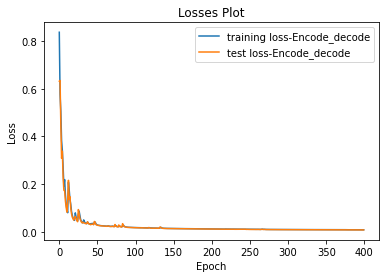

In [3]:
SEED = 123
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)        #Python
device = 'cuda' if torch.cuda.is_available() else 'cpu'    #cuda
perm_list=torch.load(dataset_dir+'/perm_list_150.pt')

print(device)
for i in range(len(perm_list[0])):
   
    perm_list[0][i]=perm_list[0][i].to(device)
print(perm_list[0][0].device)

pathE='/root/data1/circle_fenjie_EMD/Encode_state_dict.pt'
pathD='/root/data1/circle_fenjie_EMD/Decode_state_dict.pt'
pathED = '/root/data1/circle_fenjie_EMD/ED_state_dict.pt'
epochs = 400

file_path= dataset_dir+'/meshgraphnets_miniset'+str(per_t)+str(batch_size)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt'
dataset = torch.load(file_path)
print(len(dataset))
EDstats_list = get_EDstats(dataset)
[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = EDstats_list
torch.save(EDstats_list,dataset_dir+'/EDstats_list.pt')

(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))

train_size=7        #改
train_loader = DataLoader(dataset[:train_size],  shuffle=False)
valid_loader = DataLoader(dataset[train_size:], shuffle=False)#分一下训练数据和验证数据


sample = dataset[:train_size][0]
print(sample)

in_channels_node = sample.x.shape[1]
in_channels_edge = sample.edge_attr.shape[1]
hidden_channels = 25    #22#12
out_channels = in_channels_node
batch_size =25       #改
n_mlp_encode = 4
n_mlp_mp = 6#5
encoding_dim=16
ae_dim=[300,128,64,32,16]#[128,64,32,16,10]
n_mp_down = [2,2,1,1]
n_mp_up= [1,1,2,2]
pool_num = [3300,2500,1500]#[2000,1500,1200,1000][2000,1600,1400,1000]

act = F.elu
param_sharing = False

model = MessagePassing_Autoencode_attn(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')

model.to(device)
#model.load_state_dict(torch.load(pathED), strict=False)
train_hist, test_hist=train(epochs, model, perm_list,train_loader, valid_loader,per_t,batch_size,
                            EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge,pathED,pathD,pathE)
plot_dir='/root/data1/circle_fenjie_EMD/loss/'
save_DEplots(train_hist, test_hist,plot_dir)


8
8 200
200
Data(x=[3718, 2], edge_index=[2, 21714], edge_attr=[21714, 3], cells=[7139, 3], mesh_pos=[3718, 2])
torch.Size([743600, 2])
Generating velocity fields error...
200


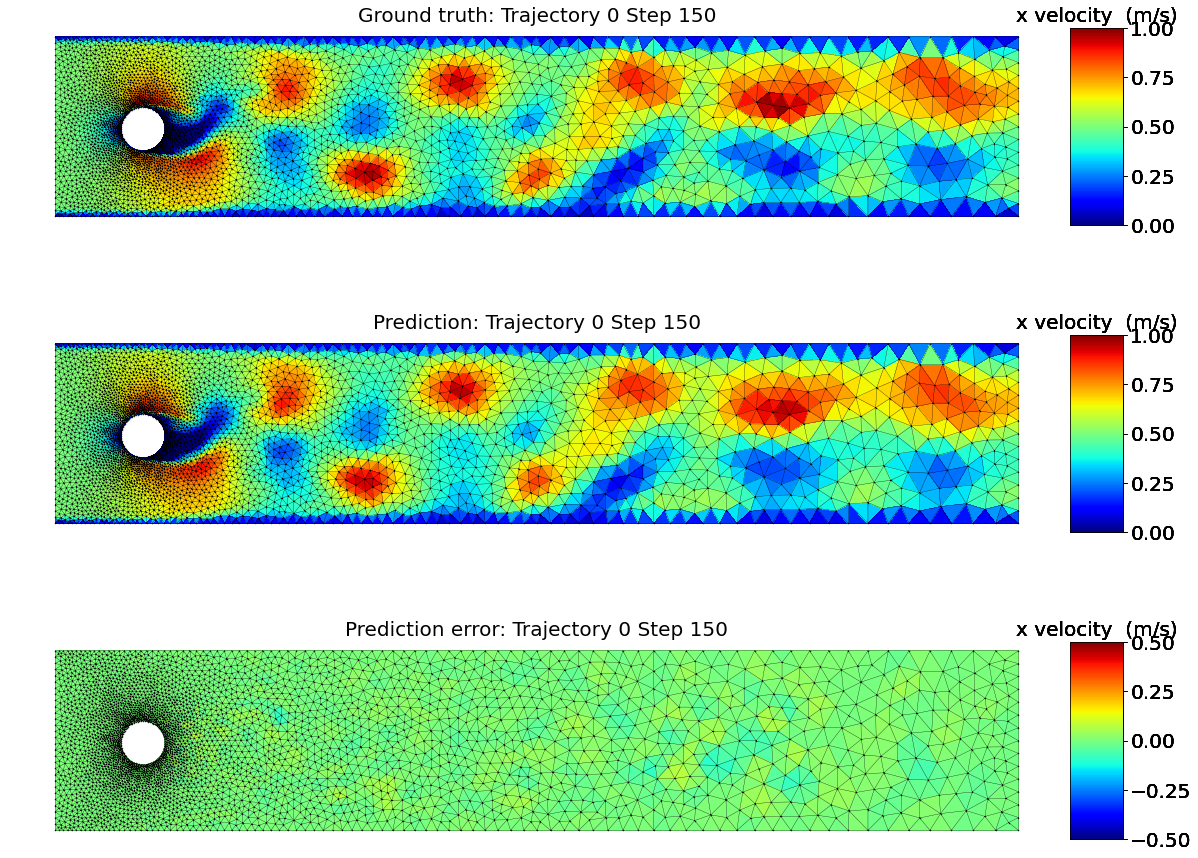

In [5]:
model = MessagePassing_Autoencode_attn(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
model.to(device)
model.load_state_dict(torch.load(pathED), strict=False)
dataset = torch.load(file_path)
print(len(dataset))   #6
n=int(len(dataset)/number_trajectories)
nn=int(n*batch_size)
print(n,nn)#6,150

#get_dataset(number_trajectories,satart_number_ts,number_ts,1,1,dataset_dir,path)

file_path_ed= dataset_dir+'/meshgraphnets_miniset'+str(1)+str(1)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt'
dataset_input = torch.load(file_path_ed)
print(len(dataset_input))  #150
print(dataset_input[0])    

for i in range(number_trajectories):
  dataset_=dataset[i*n:(i+1)*n]
  num_=int(dataset_[0].x.shape[0]/(per_t*batch_size))
  loader_ = DataLoader(dataset_,  shuffle=False)
  pred_=torch.tensor([[0,0]]).type(torch.float).to(device)
  #pred_=torch.tensor([[0]]).type(torch.float).to(device)
  per_t=1
  batch_size=25    #改
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  with torch.no_grad():
    for step, data in enumerate(loader_):
      data=data.to(device)
      
      out, _ = model(data, per_t ,perm_list[0], batch_size,EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge,batch=None, return_mask=False)
      pred_=torch.vstack((pred_,out))
  pred_=pred_[1:,:]
  print(pred_.shape)   #150*3718,2
  pred_=pred_*EDstd_vec_x+EDmean_vec_x   #pred是torch，行数为600个时间*点数，列为2
  dataset_input_=dataset_input[i*nn:(i+1)*nn]

  pred_=pred_.to('cpu')

  viz_data_loader_ = copy.deepcopy(dataset_input_)
  eval_data_loader_ = copy.deepcopy(dataset_input_)


  for j in range(int(pred_.shape[0]/num_)):
    viz_data_loader_[j].x=pred_[j*num_:(j+1)*num_,:]
    eval_data_loader_[j].x=(dataset_input_[j].x-viz_data_loader_[j].x)
  torch.save(viz_data_loader_,dataset_dir+'/encode_decode_output_'+str(i)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')#200个data
  skip=50   #每隔50个时间步画一次
  file_dir='/root/data1/circle_fenjie_EMD/animations_'+str(i)
  
  gif_name = 'Velocity'
  make_animation(dataset_input_, viz_data_loader_, eval_data_loader_,file_dir,gif_name, skip, True, False)

查看还原效果

In [3]:
SEED = 123
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)        #Python
perm_list=torch.load(dataset_dir+'/perm_list.pt')

pathE='/root/data1/circle_EMD/Encode_state_dict.pt'
pathD='/root/data1/circle_EMD/Decode_state_dict.pt'
pathED = '/root/data1/circle_EMD/ED_state_dict.pt'
epochs = 400
device = 'cuda' if torch.cuda.is_available() else 'cpu'    #cuda
file_path= dataset_dir+'/meshgraphnets_miniset'+str(per_t)+str(batch_size)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt'
dataset = torch.load(file_path)
print(len(dataset))
EDstats_list = get_EDstats(dataset)
[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = EDstats_list
torch.save(EDstats_list,dataset_dir+'/EDstats_list.pt')

(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))

train_size=4        #改
train_loader = DataLoader(dataset[:train_size],  shuffle=False)
valid_loader = DataLoader(dataset[train_size:], shuffle=False)#分一下训练数据和验证数据


sample = dataset[:train_size][0]

in_channels_node = sample.x.shape[1]
in_channels_edge = sample.edge_attr.shape[1]
hidden_channels = 25    #22#12
out_channels = in_channels_node
batch_size =25       #改
n_mlp_encode = 4
n_mlp_mp = 6#5
encoding_dim=16
ae_dim=[300,128,64,32,16]#[128,64,32,16,10]
n_mp_down = [2,2,1,1]
n_mp_up= [1,1,2,2]
pool_num = [3300,2900,2300]#[2000,1500,1200,1000][2000,1600,1400,1000]

act = F.elu
param_sharing = False

6


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


复制到文件夹查看还原效果

In [6]:
for i in range(number_trajectories):
    data=torch.load(dataset_dir+'/encode_decode_output_'+str(i)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
    print(len(data))
    print(data[0])
    num=200
    originalFolder='/root/data1/yuan_'+str(i)
    destinationFolder='/root/data1/circle_fenjie_dataset_EDoutput_'+str(i)
    fileName="/circle-2d-drag_"
    transform_vector(data, satart_number_ts,number_ts, originalFolder, destinationFolder, fileName)

200
Data(x=[3718, 2], edge_index=[2, 21714], edge_attr=[21714, 3], cells=[7139, 3], mesh_pos=[3718, 2])
start to create the destination folder
start to store data as a new variable
transform succeed


生成低维数据

In [7]:
per_t=1     #在编码和解码的时候每三个时刻个用的点是一样的
batch_size = int(number_ts/per_t)
dataset_dir = '/root/data1/circle_fenjie_EMD'
path='/root/data1/yuan_'

get_dataset(number_trajectories,satart_number_ts,number_ts,per_t,batch_size,dataset_dir,path)

file_path= dataset_dir+'/meshgraphnets_miniset'+str(per_t)+str(batch_size)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt'
dataset_M = torch.load(file_path)
print(len(dataset_M))   #长度为150  

/root/data1/yuan_0
402


2024-09-27 22:27:59.368797: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-27 22:27:59.380963: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8802 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:36:00.0, compute capability: 8.9


Done collecting data!
Done saving data!
Output Location:  /root/data1/circle_fenjie_EMD/meshgraphnets_miniset12001traj50200ts_vis.pt
1


In [8]:

M_encode=GNN_topk_encode(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
M_encode.to(device)
M_encode.load_state_dict(torch.load(pathE), strict=False)
with torch.no_grad():
  for i in range(len(dataset_M)):
    dataset_M[i]=dataset_M[i].to(device)
    data_list,batches , xs, positions, edge_attrs, edge_indices, edge_masks= M_encode(dataset_M[i], per_t , perm_list[0],
                                                                                            batch_size,EDmean_vec_x,EDstd_vec_x,
                                                                                            EDmean_vec_edge,EDstd_vec_edge,
                                                                                            batch=None, return_mask=False)  
    torch.save(data_list,dataset_dir+'/M_encode_output_'+str(i)+str(number_trajectories)+'traj'+str(per_t)+str(batch_size)+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
    torch.save(batches,dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'batches.pt')
    torch.save(xs,dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'xs.pt')
    torch.save( positions,dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'positions.pt')
    torch.save( edge_attrs,dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_attrs.pt')
    torch.save( edge_indices,dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_indices.pt')
    torch.save( edge_masks,dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_masks.pt')
    
    print(len(data_list))
    print(data_list[0],data_list[1],data_list[2],data_list[3],data_list[4],data_list[5])

200
Data(x=[1500, 25], edge_index=[2, 3476], edge_attr=[3476, 25]) Data(x=[1500, 25], edge_index=[2, 3476], edge_attr=[3476, 25]) Data(x=[1500, 25], edge_index=[2, 3476], edge_attr=[3476, 25]) Data(x=[1500, 25], edge_index=[2, 3476], edge_attr=[3476, 25]) Data(x=[1500, 25], edge_index=[2, 3476], edge_attr=[3476, 25]) Data(x=[1500, 25], edge_index=[2, 3476], edge_attr=[3476, 25])


In [9]:
per_t=1     #在编码和解码的时候每三个时刻个用的点是一样的
batch_size = int(number_ts/per_t)
a=torch.load(dataset_dir+'/M_encode_output_'+str(0)+str(number_trajectories)
                                             +'traj'+str(per_t)+str(batch_size)+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
edge_num=a[0].edge_attr.shape[0]
print(edge_num)

3476


在低维上进行时序预测

训练预测边属性模型

In [10]:
data_1=[]
data_label_1=[]

for i in range(number_trajectories):
    per_t=1
    dataset_encode=dataset_encode=torch.load(dataset_dir+'/M_encode_output_'+str(i)+str(number_trajectories)
                                             +'traj'+str(per_t)+str(batch_size)+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
    per_t=11
    for j in range(len(dataset_encode)-per_t+1):
        for k in range(per_t):
            if k <(per_t-1):
                E_data  = copy.deepcopy(dataset_encode[j+k])
                E_data=E_data.to('cpu')
                data_1.append(E_data)
            else:
                E_data  = copy.deepcopy(dataset_encode[j+k])
                E_data=E_data.to('cpu')
                data_label_1.append(E_data)
                       
print(len(data_1))      #140*10
print(len(data_label_1))   #140

data_=data_1
data_label=data_label_1



all=data_+data_label



data_stats_list = get_EDstats(all)

torch.save(data_stats_list,dataset_dir+'/data_stats_list.pt')

1900
190


In [16]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


        
for args in [
        {'model_type': 'meshgraphnet_transformer',
         'num_layers': 3,
         'batchsize': 5,       #是lable上的batchsize
         'hidden_dim': 35,      #在低维空间上的编码可以写大一点，128#30
         'hidden_channels':25,  #这里的hidden_dim与encode_decode中的hidden_channels相同
         'epochs': 4000,#5000
         'attr_epochs':8000,#8000
         'train_size':150, #45
         'test_size': 40, #10         #按照lable的来
         'device':'cuda',
         'shuffle': False,
         'save_best_model': True,
         'checkpoint_dir': '/root/data1/circle_fenjie_EMD/mgnn_transformerbest_models/',
         'postprocess_dir': '/root/data1/circle_fenjie_EMD/mgnn_transformer_loss_plots/',
         'd_k': 28,#28
         'd_v': 28,
         'input_shape': 10,   #加上时间信息，所以比n_graph_encode的最后一个多两维
         'n_heads': 5,
         'n_layers': 3,
         'ff_dim': 64,
         'seq_len': 10,        #改per_t-1,二推一
         'per_t':11,
         'attr_train_size':100,
         'attr_batchsize':5,
        'n_graph_encode':[500,150,80,8],
        'pool_num': [3300,2500,1500]},
]:

        args = objectview(args)
torch.manual_seed(5)  #Torch
random.seed(5)        #Python
np.random.seed(5)     #NumPy
torch.cuda.manual_seed_all(5)   #GPU

cuda


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training:   0%|          | 1/4000 [00:04<4:57:44,  4.47s/Epochs]

train loss 1.010557 test loss 1.267791


Training:   3%|▎         | 101/4000 [05:07<3:37:01,  3.34s/Epochs]

train loss 0.089578 test loss 0.078274


Training:   5%|▌         | 201/4000 [10:03<3:29:23,  3.31s/Epochs]

train loss 0.060045 test loss 0.036018


Training:   8%|▊         | 301/4000 [14:56<3:30:20,  3.41s/Epochs]

train loss 0.049121 test loss 0.026719


Training:  10%|█         | 401/4000 [19:55<3:31:35,  3.53s/Epochs]

train loss 0.048128 test loss 0.023085


Training:  13%|█▎        | 501/4000 [24:51<3:22:56,  3.48s/Epochs]

train loss 0.046635 test loss 0.022582


Training:  15%|█▌        | 601/4000 [29:52<3:30:18,  3.71s/Epochs]

train loss 0.044594 test loss 0.021629


Training:  18%|█▊        | 701/4000 [34:50<3:08:22,  3.43s/Epochs]

train loss 0.042369 test loss 0.01958


Training:  20%|██        | 801/4000 [39:51<3:08:59,  3.54s/Epochs]

train loss 0.044876 test loss 0.020946


Training:  23%|██▎       | 901/4000 [44:54<2:57:12,  3.43s/Epochs]

train loss 0.038257 test loss 0.016227


Training:  25%|██▌       | 1001/4000 [49:54<2:52:55,  3.46s/Epochs]

train loss 0.037974 test loss 0.016156


Training:  28%|██▊       | 1101/4000 [54:48<2:42:24,  3.36s/Epochs]

train loss 0.038501 test loss 0.015823


Training:  30%|███       | 1201/4000 [59:46<2:40:34,  3.44s/Epochs]

train loss 0.035678 test loss 0.015517


Training:  33%|███▎      | 1301/4000 [1:04:43<2:33:26,  3.41s/Epochs]

train loss 0.035313 test loss 0.014581


Training:  35%|███▌      | 1401/4000 [1:09:35<2:24:23,  3.33s/Epochs]

train loss 0.035361 test loss 0.014548


Training:  38%|███▊      | 1501/4000 [1:14:32<2:22:17,  3.42s/Epochs]

train loss 0.036335 test loss 0.014271


Training:  40%|████      | 1601/4000 [1:19:34<2:11:56,  3.30s/Epochs]

train loss 0.034519 test loss 0.013888


Training:  43%|████▎     | 1701/4000 [1:24:33<2:11:30,  3.43s/Epochs]

train loss 0.037412 test loss 0.014201


Training:  45%|████▌     | 1801/4000 [1:29:30<2:05:04,  3.41s/Epochs]

train loss 0.035433 test loss 0.013925


Training:  46%|████▌     | 1847/4000 [1:31:46<1:45:40,  2.95s/Epochs]

Epoch  1847: reducing learning rate of group 0 to 5.0000e-05.


Training:  48%|████▊     | 1901/4000 [1:34:24<1:56:21,  3.33s/Epochs]

train loss 0.033085 test loss 0.013628


Training:  50%|█████     | 2001/4000 [1:39:15<1:54:51,  3.45s/Epochs]

train loss 0.032571 test loss 0.013543


Training:  53%|█████▎    | 2101/4000 [1:44:13<1:51:01,  3.51s/Epochs]

train loss 0.032472 test loss 0.01355


Training:  55%|█████▌    | 2201/4000 [1:49:12<1:49:35,  3.65s/Epochs]

train loss 0.032545 test loss 0.013434


Training:  58%|█████▊    | 2301/4000 [1:54:14<1:38:24,  3.48s/Epochs]

train loss 0.031961 test loss 0.013253


Training:  60%|██████    | 2401/4000 [1:59:15<1:32:08,  3.46s/Epochs]

train loss 0.031543 test loss 0.013249


Training:  63%|██████▎   | 2501/4000 [2:04:21<1:32:58,  3.72s/Epochs]

train loss 0.031993 test loss 0.013387


Training:  65%|██████▌   | 2601/4000 [2:09:19<1:17:40,  3.33s/Epochs]

train loss 0.031875 test loss 0.013077


Training:  68%|██████▊   | 2701/4000 [2:14:22<1:14:24,  3.44s/Epochs]

train loss 0.032979 test loss 0.013147


Training:  70%|██████▉   | 2782/4000 [2:18:21<1:00:36,  2.99s/Epochs]

Epoch  2782: reducing learning rate of group 0 to 2.5000e-05.


Training:  70%|███████   | 2801/4000 [2:19:18<1:06:57,  3.35s/Epochs]

train loss 0.030832 test loss 0.013108


Training:  72%|███████▏  | 2883/4000 [2:23:24<54:15,  2.91s/Epochs]  

Epoch  2883: reducing learning rate of group 0 to 1.2500e-05.


Training:  73%|███████▎  | 2901/4000 [2:24:20<1:02:11,  3.40s/Epochs]

train loss 0.030753 test loss 0.012955


Training:  75%|███████▍  | 2984/4000 [2:28:22<49:18,  2.91s/Epochs]  

Epoch  2984: reducing learning rate of group 0 to 6.2500e-06.


Training:  75%|███████▌  | 3001/4000 [2:29:13<56:25,  3.39s/Epochs]

train loss 0.030632 test loss 0.012911


Training:  77%|███████▋  | 3085/4000 [2:33:21<44:44,  2.93s/Epochs]

Epoch  3085: reducing learning rate of group 0 to 3.1250e-06.


Training:  78%|███████▊  | 3101/4000 [2:34:10<50:54,  3.40s/Epochs]

train loss 0.030911 test loss 0.01295


Training:  80%|███████▉  | 3186/4000 [2:38:26<38:29,  2.84s/Epochs]

Epoch  3186: reducing learning rate of group 0 to 1.5625e-06.


Training:  80%|████████  | 3201/4000 [2:39:11<44:59,  3.38s/Epochs]

train loss 0.030618 test loss 0.012944


Training:  82%|████████▏ | 3287/4000 [2:43:24<36:32,  3.08s/Epochs]

Epoch  3287: reducing learning rate of group 0 to 1.0000e-06.


Training:  83%|████████▎ | 3301/4000 [2:44:08<40:01,  3.43s/Epochs]

train loss 0.031284 test loss 0.012908


Training:  85%|████████▌ | 3401/4000 [2:49:22<36:17,  3.64s/Epochs]

train loss 0.02983 test loss 0.012925


Training:  88%|████████▊ | 3501/4000 [2:54:21<28:02,  3.37s/Epochs]

train loss 0.029999 test loss 0.012923


Training:  90%|█████████ | 3601/4000 [2:59:18<22:31,  3.39s/Epochs]

train loss 0.030569 test loss 0.012906


Training:  93%|█████████▎| 3701/4000 [3:04:19<17:11,  3.45s/Epochs]

train loss 0.030305 test loss 0.012907


Training:  95%|█████████▌| 3801/4000 [3:09:23<11:21,  3.42s/Epochs]

train loss 0.030276 test loss 0.012896


Training:  98%|█████████▊| 3901/4000 [3:14:20<05:32,  3.35s/Epochs]

train loss 0.030859 test loss 0.012876


Training: 100%|██████████| 4000/4000 [3:19:20<00:00,  2.99s/Epochs]

Min test set loss: 0.012782794423401356
Minimum loss: 0.029507128925373157


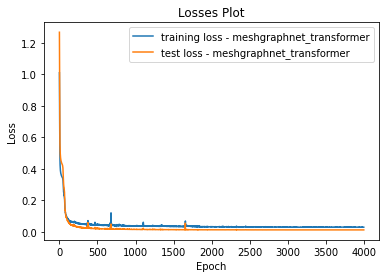

In [17]:
data_stats_list=torch.load(dataset_dir+'/data_stats_list.pt')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.device = device
print(device)

test_losses, losses, best_model,best_test_loss =gmesh_transformer_train(data_,data_label, device,data_stats_list, args,edge_num)
print("Min test set loss: {0}".format(min(test_losses)))
print("Minimum loss: {0}".format(min(losses)))

save_plots(args, losses, test_losses)

In [18]:
per_t=1     #在编码和解码的时候每三个时刻个用的点是一样的
batch_size = int(number_ts/per_t)
data_encode=torch.load(dataset_dir+'/M_encode_output_'+str(0)+str(number_trajectories)
                                             +'traj'+str(per_t)+str(batch_size)+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
print(len(data_encode))
data=copy.deepcopy(data_encode[0:10])
a=copy.deepcopy(data_encode[0])
print(a)

200
Data(x=[1500, 25], edge_index=[2, 3476], edge_attr=[3476, 25])


In [20]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d        
for args in [
        {'model_type': 'meshgraphnet_transformer',
         'num_layers': 3,
         'batchsize': 5,       #是lable上的batchsize
         'hidden_dim': 35,      #在低维空间上的编码可以写大一点，128#30
         'hidden_channels':25,  #这里的hidden_dim与encode_decode中的hidden_channels相同
         'epochs': 4000,#5000
         'attr_epochs':8000,#8000
         'train_size':150, #45
         'test_size': 40, #10         #按照lable的来
         'device':'cuda',
         'shuffle': False,
         'save_best_model': True,
         'checkpoint_dir': '/root/data1/circle_fenjie_EMD/mgnn_transformerbest_models/',
         'postprocess_dir': '/root/data1/circle_fenjie_EMD/mgnn_transformer_loss_plots/',
         'd_k': 28,#28
         'd_v': 28,
         'input_shape': 10,   #加上时间信息，所以比n_graph_encode的最后一个多两维
         'n_heads': 5,
         'n_layers': 3,
         'ff_dim': 64,
         'seq_len': 10,        #改per_t-1,二推一
         'per_t':11,
         'attr_train_size':100,
         'attr_batchsize':5,
        'n_graph_encode':[500,150,80,8],
        'pool_num': [3300,2500,1500]},
]:
        args = objectview(args)
    
model_name='g_trans_model_nl'+str(args.num_layers)+'_bs'+str(args.batchsize) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd' + \
               '_shuff_'+str(args.shuffle)+'_dk'+str(args.d_k)+'_heads'+str(args.n_heads)
args.batchsize=1
node_model = MeshGraphNet_transformer(args,edge_num).to(device)
node_model.load_state_dict(torch.load('/root/data1/circle_fenjie_EMD/mgnn_transformerbest_models/'+model_name+'.pt'))

EDstats_list=torch.load(dataset_dir+'/EDstats_list.pt')
data_stats_list=torch.load(dataset_dir+'/data_stats_list.pt')
[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = EDstats_list
(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))
[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge] = data_stats_list
(mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)=(mean_vec_x.to(device),std_vec_x.to(device),
                                                   mean_vec_edge.to(device),std_vec_edge.to(device))

In [21]:
def predict_sequences_multiple(model, data, a, predict_num,seq_len):

        print('[Model] Predicting Sequences Multiple...')
        a=a.to(device)
        code_index=a.edge_index
        for i in range(predict_num):
          list_p = data[:] if i == 0 else data[i:]
          data_loader=DataLoader(list_p, batch_size=seq_len, shuffle=False) 
          for i,batch in enumerate(data_loader):
              batch=batch.to(device)
              code_x,code_edge_attr = gmesh_transformer_pred(batch,a,model,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)
          
          new_data=Data(x=code_x, edge_index=code_index, edge_attr=code_edge_attr)
          data.append(new_data)

        return data

In [22]:
predict_num=190
seq_len=10
data=predict_sequences_multiple(node_model, data, a, predict_num,seq_len)
print(len(data))  #60

[Model] Predicting Sequences Multiple...


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


200


In [24]:
i=0
batches=torch.load(dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'batches.pt')
xs=torch.load(dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'xs.pt')
positions=torch.load( dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'positions.pt')
edge_attrs=torch.load( dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_attrs.pt')
edge_indices=torch.load( dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_indices.pt')
edge_masks=torch.load(dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_masks.pt')


perm_list=torch.load(dataset_dir+'/perm_list_150.pt')


decode_model=GNN_Decode(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
decode_model.load_state_dict(torch.load(pathD), strict=False)
decode_model.to(device)

pred_x=[]
with torch.no_grad():
        for i in range(len(data)):
              x=decode_model(data[i], batches , xs, positions, edge_attrs, edge_indices, edge_masks,perm_list[0])
              x=x*EDstd_vec_x+EDmean_vec_x
              pred_x.append(x)

              
print(len(pred_x))

200


In [25]:
def ROM_transform_vector(data, satart_number_ts,number_ts, originalFolder, destinationFolder, fileName):

    folder = os.path.exists(destinationFolder)

    if not folder: 
        print('start to create the destination folder')   
        os.makedirs(destinationFolder)       
        copyFiles(originalFolder,destinationFolder) 

    print('start to store data as a new variable')
    
    for i in range(number_ts):
        f_filename = destinationFolder + fileName + str(i+satart_number_ts)+ ".vtu"
        mesh =meshio.read(f_filename)
        a=data[i].to('cpu')
        a=a.numpy()
        #a=a.reshape(a.shape[0])
        #print(mesh.point_data["Velocity"][45:55])
        #print(a[45:55])
        #mesh.point_data["Temperature"]=a
        mesh.point_data["Velocity"][:,0:2]=a
        
        #print(mesh.point_data["Velocity"][45:55])
        meshio.write(f_filename, mesh)
    print('transform succeed')	

In [26]:
for i in range(number_trajectories):
    satart_number_ts=50
    ts=len(pred_x)
    originalFolder='/root/data1/yuan_'+str(i)
    destinationFolder='/root/data1/ROM_circle_fenjie_dataset_EDoutput_'+str(predict_num)+str(i)
    fileName="/circle-2d-drag_"
    ROM_transform_vector(pred_x, satart_number_ts,ts, originalFolder, destinationFolder, fileName)

start to create the destination folder
start to store data as a new variable
transform succeed


In [2]:
def pcc_of_two(ori_data, rom_data):

    if ori_data.ndim == rom_data.ndim:
        if rom_data.ndim == 3:
            y_u = ori_data[...,0] # u
            y_v = ori_data[...,1] # v
            y_0_u = rom_data[...,0] # u
            y_0_v = rom_data[...,1] # v
            pcc_x = pearson_value(y_u, y_0_u)
            pcc_y = pearson_value(y_v, y_0_v)
            plt.figure(1)
            plt.plot(pcc_x)
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('Pearson Correlation Coefficient of x axis',{'size' : 11})
            plt.figure(2)
            plt.plot(pcc_y)
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('Pearson Correlation Coefficient of y axis',{'size' : 11})
            plt.show()
        elif rom_data.ndim == 2:
            pcc = pearson_value(ori_data, rom_data)
            # print(pcc.shape)
            plt.figure(1)
            # x = np.linspace(0,pcc.shape[0], num = pcc.shape[0])
            plt.plot(pcc)
            plt.ylim((0, 1))
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('Pearson Correlation Coefficient',{'size' : 11})
            plt.show()
    else:
        print('the dimension of these two series are not equal. Please check them.')

200
(200, 7436) (200, 7436)


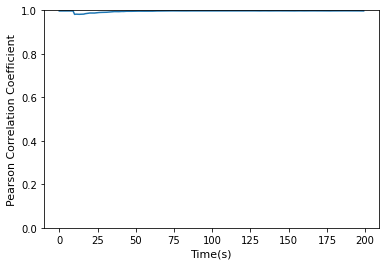

In [28]:
ED_out = pred_x   #60
ori=torch.load(dataset_dir+'/meshgraphnets_miniset'+str(1)+str(1)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
print(len(ori))   #150
ori=ori[0:200]

ts=200

for i in range(ts):
    
    uvw=ED_out[i].reshape(1,ED_out[i].shape[0],ED_out[i].shape[1]).to('cpu')
    ouvw=ori[i].x.reshape(1,ori[i].x.shape[0],ori[i].x.shape[1])
    outputs = uvw if i==0 else np.vstack((outputs,uvw))
    inputs=ouvw if i==0 else np.vstack((inputs,ouvw))

output_ = np.hstack((outputs[:,:,0],outputs[:,:,1]))
input_ = np.hstack((inputs[:,:,0],inputs[:,:,1]))
print(output_.shape,input_.shape)

pcc_of_two(input_, output_)

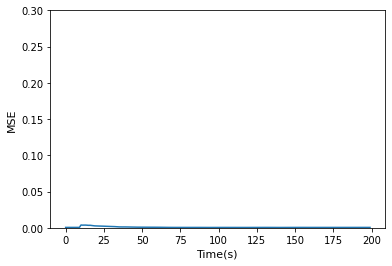

In [29]:
mse_of_two(input_, output_)

在未见数据上，给定10个时刻数据，预测后续时间结果

In [30]:
SEED = 123
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)        #Python
device = 'cuda' if torch.cuda.is_available() else 'cpu'    #cuda
perm_list=torch.load(dataset_dir+'/perm_list_150.pt')

print(device)
for i in range(len(perm_list[0])):
   
    perm_list[0][i]=perm_list[0][i].to(device)
print(perm_list[0][0].device)

pathE='/root/data1/circle_fenjie_EMD/Encode_state_dict.pt'
pathD='/root/data1/circle_fenjie_EMD/Decode_state_dict.pt'
pathED = '/root/data1/circle_fenjie_EMD/ED_state_dict.pt'
epochs = 400

file_path= dataset_dir+'/meshgraphnets_miniset'+str(per_t)+str(batch_size)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt'
dataset = torch.load(file_path)
print(len(dataset))
EDstats_list = get_EDstats(dataset)
#[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = EDstats_list
#torch.save(EDstats_list,dataset_dir+'/EDstats_list.pt')
EDstats_list = torch.load(dataset_dir+'/EDstats_list.pt')

[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = EDstats_list
(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))

train_size=7        #改
train_loader = DataLoader(dataset[:train_size],  shuffle=False)
valid_loader = DataLoader(dataset[train_size:], shuffle=False)#分一下训练数据和验证数据


sample = dataset[:train_size][0]
print(sample)

in_channels_node = sample.x.shape[1]
in_channels_edge = sample.edge_attr.shape[1]
hidden_channels = 25    #22#12
out_channels = in_channels_node
batch_size =25       #改
n_mlp_encode = 4
n_mlp_mp = 6#5
encoding_dim=16
ae_dim=[300,128,64,32,16]#[128,64,32,16,10]
n_mp_down = [2,2,1,1]
n_mp_up= [1,1,2,2]
pool_num = [3300,2500,1500]#[2000,1500,1200,1000][2000,1600,1400,1000]

act = F.elu
param_sharing = False

cuda
cuda:0
1
Data(x=[743600, 2], edge_index=[2, 21714], edge_attr=[21714, 3], cells=[7139, 3], mesh_pos=[3718, 2])


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [31]:
M_encode=GNN_topk_encode(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
M_encode.to(device)
M_encode.load_state_dict(torch.load(pathE), strict=False)


decode_model=GNN_Decode(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
decode_model.load_state_dict(torch.load(pathD), strict=False)
decode_model.to(device)

AttributeError: 'Global_attention' object has no attribute 'min_score'

In [32]:
per_t=1     
satart_number_ts=250
number_ts=10
batch_size = int(number_ts/per_t)
dataset_dir = '/root/data1/circle_fenjie_EMD'
path='/root/data1/yuan_'     #将文件命名为yuan_0
number_trajectories=1

get_dataset(number_trajectories,satart_number_ts,number_ts,per_t,batch_size,dataset_dir,path)

file_path= dataset_dir+'/meshgraphnets_miniset'+str(per_t)+str(batch_size)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt'
dataset_M = torch.load(file_path)
print(len(dataset_M))   #长度为1  

perm_list=torch.load(dataset_dir+'/perm_list_150.pt')

print(device)
for i in range(len(perm_list[0])):
   
    perm_list[0][i]=perm_list[0][i].to(device)
print(perm_list[0][0].device)




with torch.no_grad():
  for i in range(len(dataset_M)):
    dataset_M[i]=dataset_M[i].to(device)
    data_list,batches , xs, positions, edge_attrs, edge_indices, edge_masks= M_encode(dataset_M[i], per_t , perm_list[0],
                                                                                            batch_size,EDmean_vec_x,EDstd_vec_x,
                                                                                            EDmean_vec_edge,EDstd_vec_edge,
                                                                                            batch=None, return_mask=False)  
    torch.save(data_list,dataset_dir+'/M_encode_output_'+str(i)+str(number_trajectories)+'traj'+str(per_t)+str(batch_size)+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
    torch.save(batches,dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'batches.pt')
    torch.save(xs,dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'xs.pt')
    torch.save( positions,dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'positions.pt')
    torch.save( edge_attrs,dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_attrs.pt')
    torch.save( edge_indices,dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_indices.pt')
    torch.save( edge_masks,dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_masks.pt')
    
    print(len(data_list))#10
    print(data_list[0],data_list[1],data_list[2],data_list[3],data_list[4],data_list[5])

/root/data1/yuan_0
402
Done collecting data!
Done saving data!
Output Location:  /root/data1/circle_fenjie_EMD/meshgraphnets_miniset1101traj25010ts_vis.pt
1
cuda
cuda:0
10
Data(x=[1500, 25], edge_index=[2, 3476], edge_attr=[3476, 25]) Data(x=[1500, 25], edge_index=[2, 3476], edge_attr=[3476, 25]) Data(x=[1500, 25], edge_index=[2, 3476], edge_attr=[3476, 25]) Data(x=[1500, 25], edge_index=[2, 3476], edge_attr=[3476, 25]) Data(x=[1500, 25], edge_index=[2, 3476], edge_attr=[3476, 25]) Data(x=[1500, 25], edge_index=[2, 3476], edge_attr=[3476, 25])


In [33]:
per_t=1     
batch_size = int(number_ts/per_t)
data_encode=torch.load(dataset_dir+'/M_encode_output_'+str(0)+str(number_trajectories)
                                             +'traj'+str(per_t)+str(batch_size)+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
print(len(data_encode)) #10
data=copy.deepcopy(data_encode[0:10])
a=copy.deepcopy(data_encode[0])
print(a)

10
Data(x=[1500, 25], edge_index=[2, 3476], edge_attr=[3476, 25])


In [34]:
edge_num=a.edge_attr.shape[0]
print(edge_num)#9762

3476


In [35]:
predict_num=140
seq_len=10
data=predict_sequences_multiple(node_model, data, a, predict_num,seq_len)
print(len(data))  #60

[Model] Predicting Sequences Multiple...
150


In [36]:
i=0
batches=torch.load(dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'batches.pt')
xs=torch.load(dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'xs.pt')
positions=torch.load( dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'positions.pt')
edge_attrs=torch.load( dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_attrs.pt')
edge_indices=torch.load( dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_indices.pt')
edge_masks=torch.load(dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_masks.pt')




perm_list=torch.load(dataset_dir+'/perm_list_150.pt')


pred_x=[]
with torch.no_grad():
        for i in range(len(data)):
              x=decode_model(data[i], batches , xs, positions, edge_attrs, edge_indices, edge_masks,perm_list[0])
              x=x*EDstd_vec_x+EDmean_vec_x
              pred_x.append(x)

              
print(len(pred_x))

150


In [37]:
for i in range(number_trajectories):
    satart_number_ts=250
    ts=len(pred_x)
    originalFolder='/root/data1/yuan_'+str(i)
    destinationFolder='/root/data1/ROM_pred_circle_fenjie_dataset_EDoutput_'+str(predict_num)+str(i)
    fileName="/circle-2d-drag_"
    ROM_transform_vector(pred_x, satart_number_ts,ts, originalFolder, destinationFolder, fileName)

start to create the destination folder
start to store data as a new variable
transform succeed


In [2]:
def pcc_of_two(ori_data, rom_data):

    if ori_data.ndim == rom_data.ndim:
        if rom_data.ndim == 3:
            y_u = ori_data[...,0] # u
            y_v = ori_data[...,1] # v
            y_0_u = rom_data[...,0] # u
            y_0_v = rom_data[...,1] # v
            pcc_x = pearson_value(y_u, y_0_u)
            pcc_y = pearson_value(y_v, y_0_v)
            plt.figure(1)
            plt.plot(pcc_x)
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('Pearson Correlation Coefficient of x axis',{'size' : 11})
            plt.figure(2)
            plt.plot(pcc_y)
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('Pearson Correlation Coefficient of y axis',{'size' : 11})
            plt.show()
        elif rom_data.ndim == 2:
            pcc = pearson_value(ori_data, rom_data)
            # print(pcc.shape)
            f=plt.figure(1)
            # x = np.linspace(0,pcc.shape[0], num = pcc.shape[0])
            plt.plot(pcc)
            plt.ylim((0.9, 1))
            plt.xlabel('Time Level',{'size' : 11})
            plt.ylabel('Pearson Correlation Coefficient',{'size' : 11})
            plt.show()
            f.savefig('/root/data1/circle_fenjie_EMD/pcc_pre_circle_140.pdf', bbox_inches='tight')
    else:
        print('the dimension of these two series are not equal. Please check them.')
   

In [3]:
def get(number_trajectories,satart_number_ts,number_ts,path):
  data_list = []

  for i in range(number_trajectories):

    if os.path.isdir(path):
      path_k=path
      print(path_k)
      vtk_num=get_vtu_num(path_k)
      print(vtk_num)
      for ts in range(satart_number_ts,vtk_num):
        
        if(ts==number_ts+satart_number_ts):
          break
        mesh = meshio.read(path_k+"/circle-2d-drag_"+str(ts+i)+".vtu")
             
        velocity = mesh.point_data["Velocity"][:, [0,1]]  # u,v方向速度
        velocity = torch.tensor(velocity).type(torch.float)
        
        data_list.append(Data(x=velocity))
  return data_list

In [4]:
import os

In [4]:
dataset_dir = '/root/data1/circle_fenjie_EMD'
number_trajectories=1
satart_number_ts=250
number_ts=150
path='/root/data1/ROM_pred_circle_fenjie_dataset_EDoutput_1400'
ED_out=get(number_trajectories,satart_number_ts,number_ts,path)
print(ED_out)
ED_out=ED_out[0:150]

/root/data1/ROM_pred_circle_fenjie_dataset_EDoutput_1400
402
[Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=[3718, 2]), Data(x=

150
(150, 7436) (150, 7436)


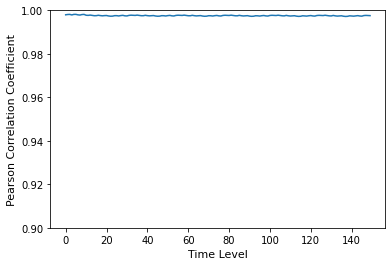

In [5]:


#get_dataset(number_trajectories,satart_number_ts,number_ts,1,1,dataset_dir,path)
ori=torch.load(dataset_dir+'/meshgraphnets_miniset'+str(1)+str(1)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
print(len(ori))   #150
ori=ori[0:150]

ts=150

for i in range(ts):
    
    uvw=ED_out[i].x.reshape(1,ED_out[i].x.shape[0],ED_out[i].x.shape[1]).to('cpu')
    ouvw=ori[i].x.reshape(1,ori[i].x.shape[0],ori[i].x.shape[1])
    outputs = uvw if i==0 else np.vstack((outputs,uvw))
    inputs=ouvw if i==0 else np.vstack((inputs,ouvw))

output_ = np.hstack((outputs[:,:,0],outputs[:,:,1]))
input_ = np.hstack((inputs[:,:,0],inputs[:,:,1]))
print(output_.shape,input_.shape)

pcc_of_two(input_, output_)

In [6]:
from keras import backend as K

In [7]:

def root_mean_squared_error(true, pred):
    return K.mean(K.square(pred - true))
def mse(ori_data, rom_data):
    rmse_value = []
    if len(ori_data) != len(rom_data):
        print('the length of these two array do not match')
    else:
        for i in range(len(rom_data)):
            value = np.sqrt(root_mean_squared_error(ori_data[i], rom_data[i]))
           
            if i == 0:
                rmse_value = value
            else:
                rmse_value = np.hstack((rmse_value,value))
        rmse_value = np.reshape(rmse_value,(-1,1))
    return rmse_value

In [8]:
def mse_of_two(ori_data, rom_data):
    # , rom_data_1):
    
    rmse_value = mse(ori_data, rom_data)
            # rmse_value_1 = rmse(ori_data, rom_data_1)
            # print(pcc.shape[0], pcc.shape[1])
    f=plt.figure(1)
            # x = np.linspace(0,rmse_value.shape[0], rmse_value.shape[0])
            # plt.plot(x, rmse_value, x, rmse_value_1)
    plt.plot(rmse_value)
    plt.ylim((-0.005, 0.15))
    plt.xlabel('Time Level',{'size' : 11})
    plt.ylabel('RMSE',{'size' : 11})
            # plt.legend(['7', '8'], loc='lower right')   
    plt.show()
    f.savefig('/root/data1/circle_fenjie_EMD/Rmse_pre_circle_140.pdf', bbox_inches='tight')
    

2024-11-23 19:54:24.624279: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-23 19:54:27.942251: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20970 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:9a:00.0, compute capability: 8.9


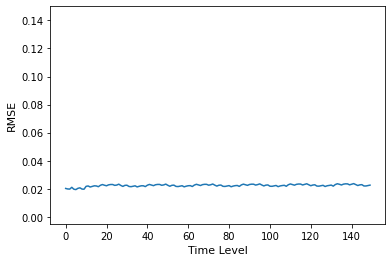

In [9]:
mse_of_two(input_, output_)